In [1]:
import Experiments_Module as exp

In [2]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from scipy.linalg import qr
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

from pylab import rcParams
rcParams['figure.figsize'] = 14, 12  # делаем картинки крупнее
get_ipython().magic("config InlineBackend.figure_format = 'retina'  # делаем картинки красивее")

pd.options.display.max_rows = 20

Эксперименты проводятся по следующей схеме.
- из датасета загружается набор данных для обучения, тестовые данные и правильный ответ
- применяются IsolationForest и modIsolationForest: обучаются на данных обучения, предсказывают ответ для нормалий и для аномалий. Результат оценивается по метрике AUC-ROC
- для результата запускается метод ножниц. Метод сначала рисует общую картинку процесса: 4 графика: Differences descending - убывание максимального расстояния между соседними объектами в одном кусочке, достаточно бесполезная вещь. T - размер самого большого получившегося кластера аномалий. Может быть полезно, если есть информация о том, что аномалии образуют кластера. Fraction of anomalies in forecast - самое интересное. Наконец, Number of normalies clusters - количество кластеров нормалий
- Поскольку работаем с результатом изолирующего леса, Number of normalies clusters должно равняться по логике 1. Ограничим fraction of anomalies in forecast 0.5. Тогда ножницы сужает множество вариантов для ответа.
- Из предложенных вариантов я выбираю один, основываясь на несильных соображениях, и оцениваю F-меру. Примечание: ножницы иногда обрезают ответы со слишком высоким anomaly_score. Казалось бы, что это неверно, но эксперименты сомневаются, поэтому пока пусть так.
- Затем я смотрю, какую F-меру можно было бы теоретически выжать из получившихся скоров.

# IONOSPHERE

Данные радаров, на которых тестировали нейронки. Для каждого набора из 33 вещественных признаков известно, нормальные или это данные или нет. Для трэйна (200 объектов) соотношение нормалий и аномалий 50-50, что ужасно. На тесте аномалий достаточно мало (24 из 147). Нейронка, кстати, добилась accuracy 96,7%. 

In [3]:
DF = pd.read_csv("ionosphere.csv", sep=';', header=None)
ans = (DF[34] == 'b')[200:]
del DF[34]

DF, DF_test = DF[:200], DF[200:]
DF

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697
5,1,0,0.02337,-0.00592,-0.09924,-0.11949,-0.00763,-0.11824,0.14706,0.06637,...,0.03513,-0.01535,-0.03240,0.09223,-0.07859,0.00732,0.00000,0.00000,-0.00039,0.12011
6,1,0,0.97588,-0.10602,0.94601,-0.20800,0.92806,-0.28350,0.85996,-0.27342,...,0.22792,-0.81634,0.13659,-0.82510,0.04606,-0.82395,-0.04262,-0.81318,-0.13832,-0.80975
7,0,0,0.00000,0.00000,0.00000,0.00000,1.00000,-1.00000,0.00000,0.00000,...,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000
8,1,0,0.96355,-0.07198,1.00000,-0.14333,1.00000,-0.21313,1.00000,-0.36174,...,0.85106,-0.65440,0.57577,-0.69712,0.25435,-0.63919,0.45114,-0.72779,0.38895,-0.73420
9,1,0,-0.01864,-0.08459,0.00000,0.00000,0.00000,0.00000,0.11470,-0.26810,...,-0.14803,-0.01326,0.20645,-0.02294,0.00000,0.00000,0.16595,0.24086,-0.08208,0.38065


AUC-ROC score:  0.82825567503


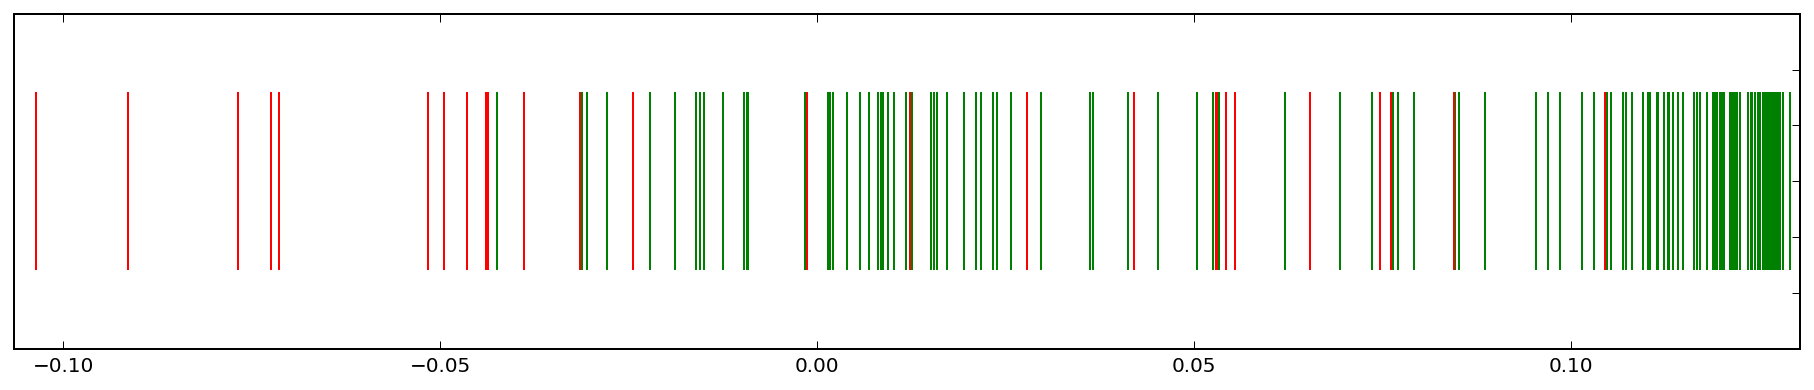

In [4]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.853643966547


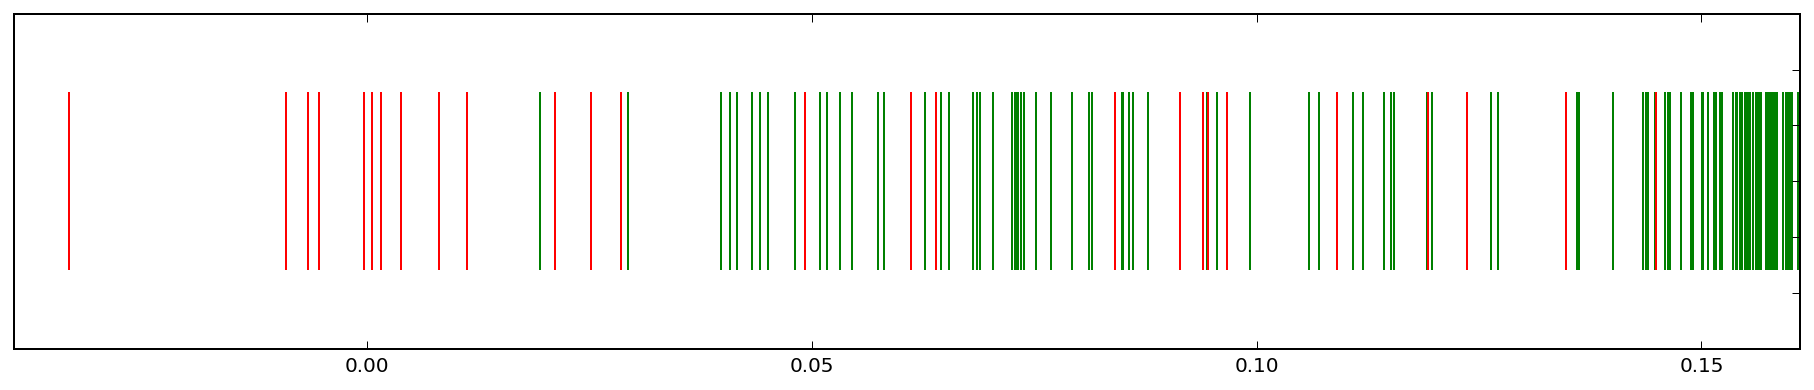

In [5]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.881123058542


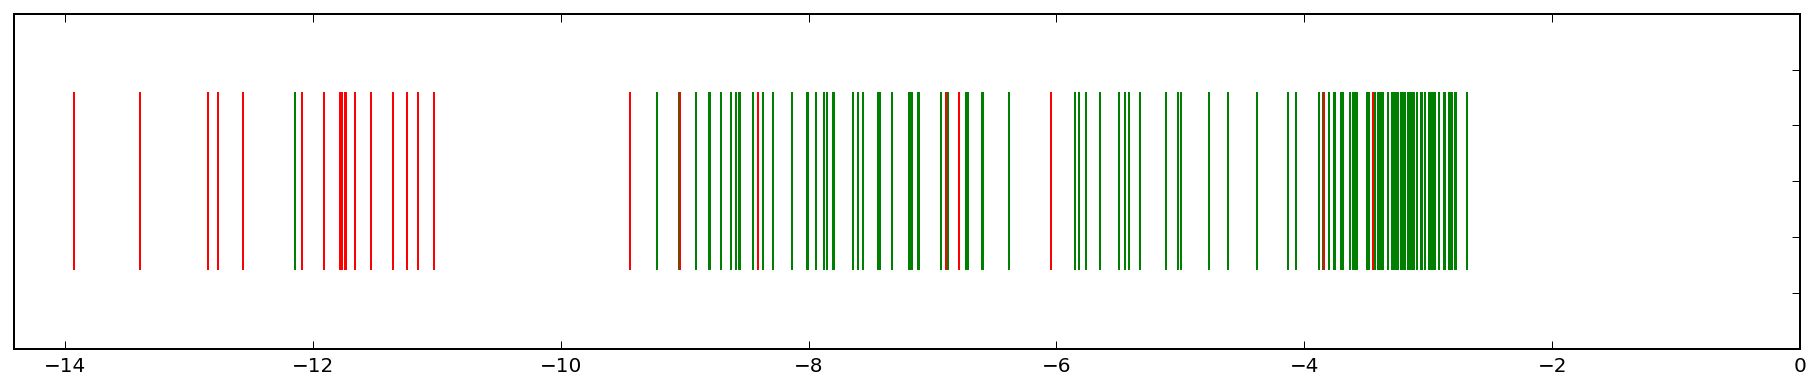

In [4]:
normaly_score, anomaly_score = exp.Solve(exp.PolinomSolver(), DF, DF_test[~ans], DF_test[ans])

manhattan: 0.792712066906

euclidean: 0.822580645161

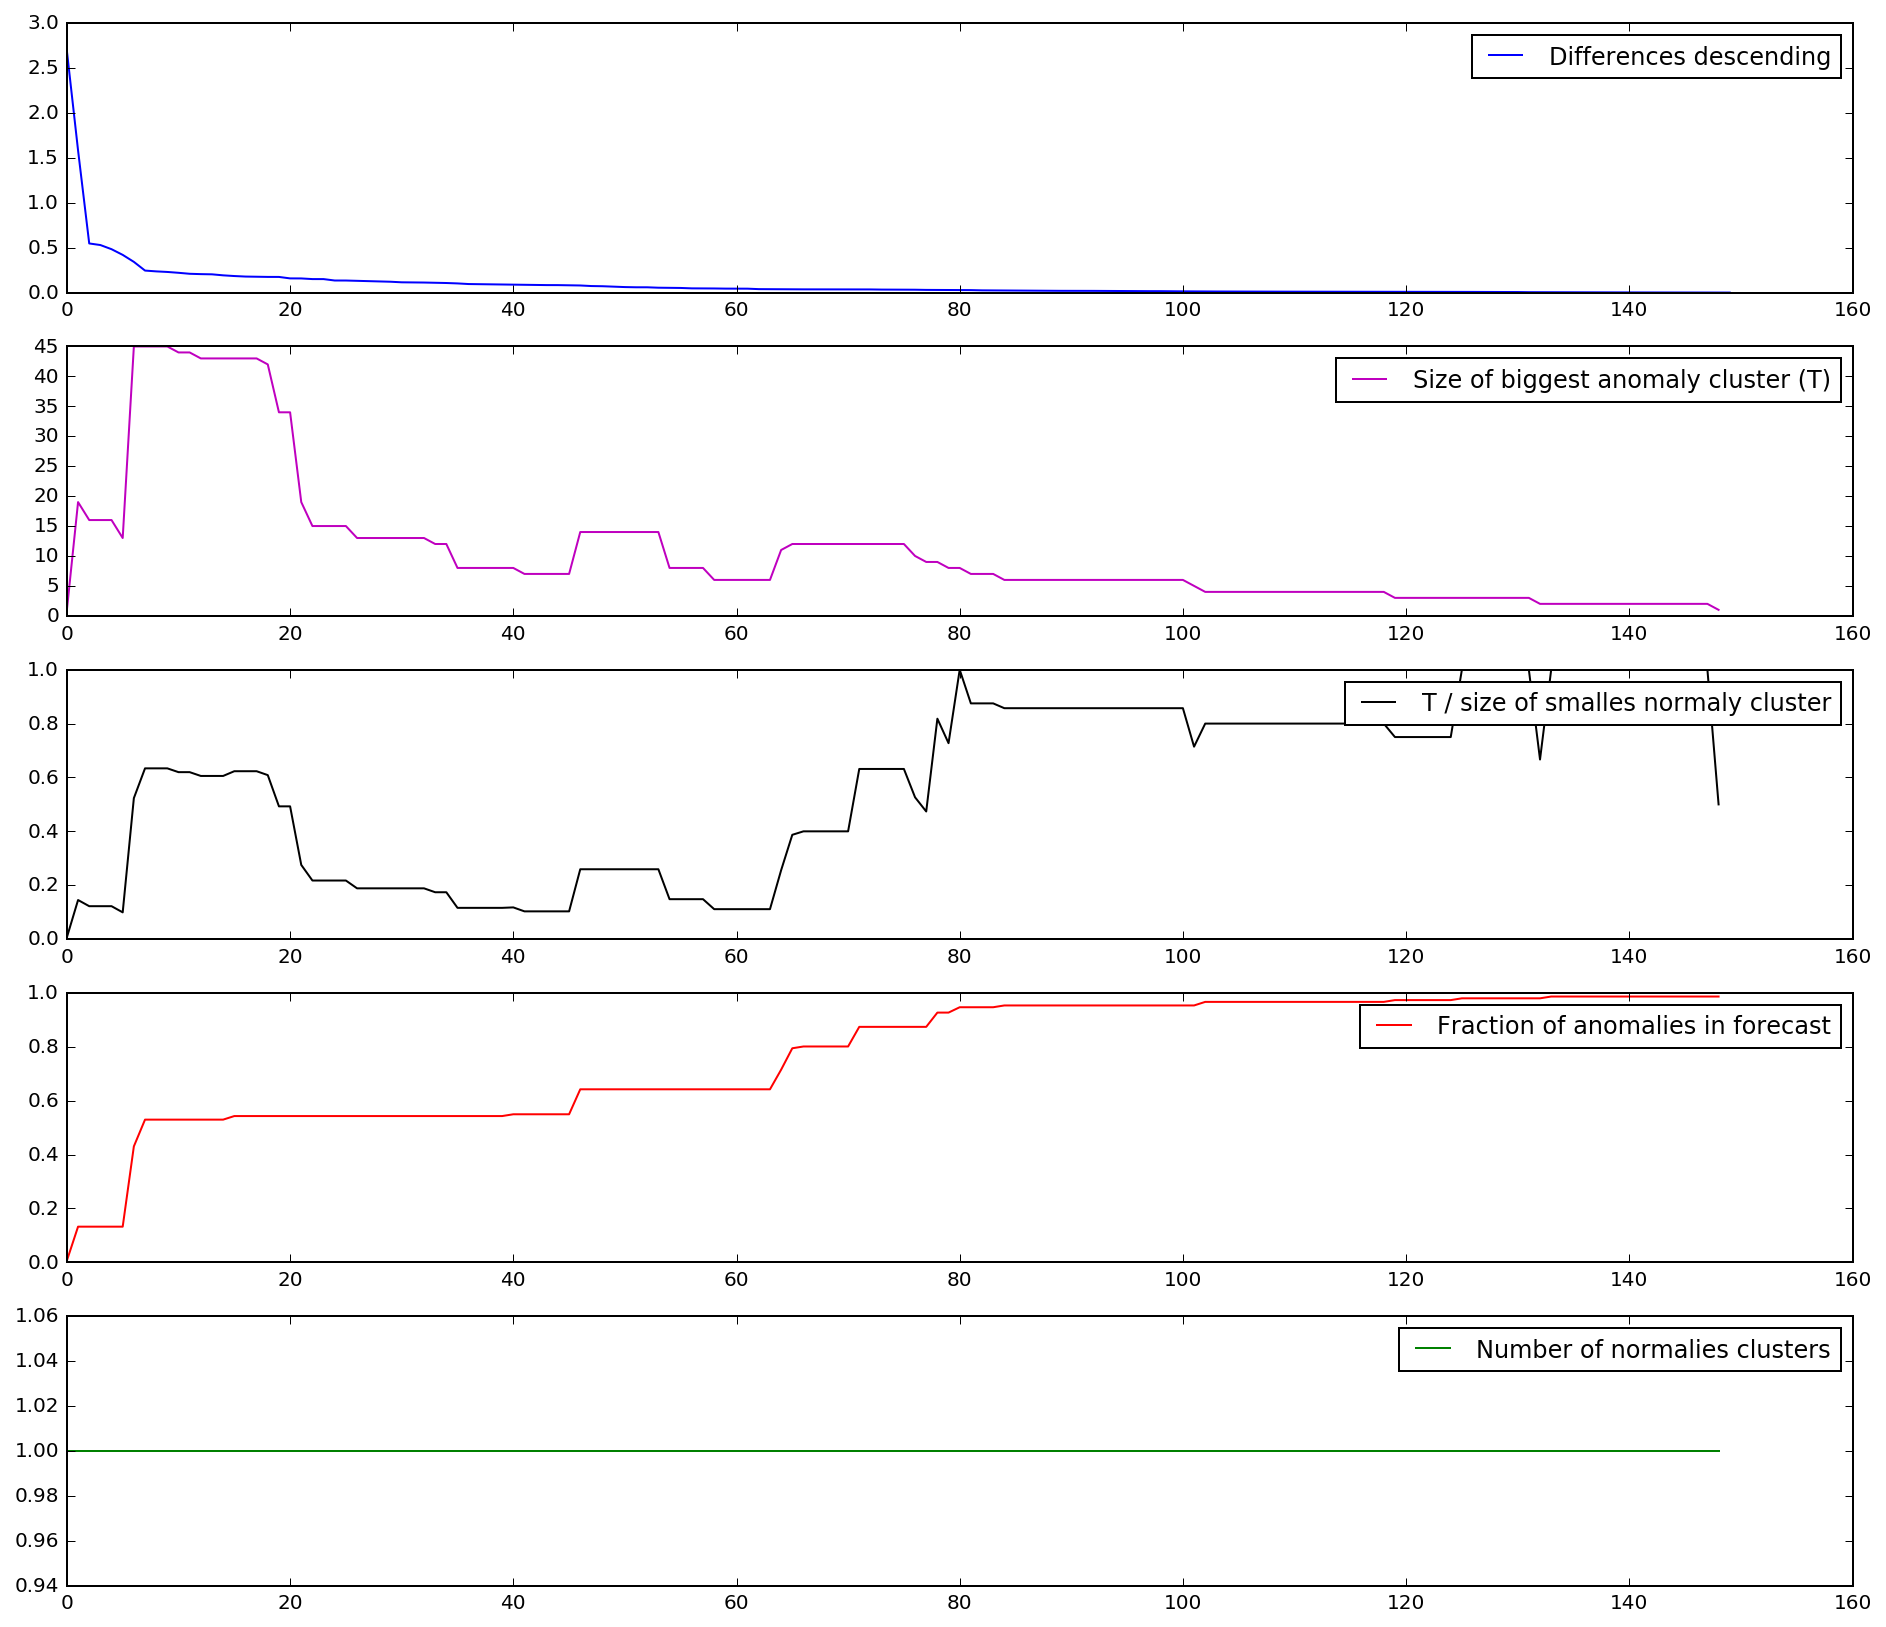

In [6]:
exp.analize_threshold(normaly_score, anomaly_score, -1, 1)

In [7]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

T-variant: n_splits= 6 T =  13 T_frac =  0.0992366412214 , anom_frac =  0.132450331126


T =  13
T_frac =  0.0992366412214
Anomalies Fraction =  0.132450331126 %


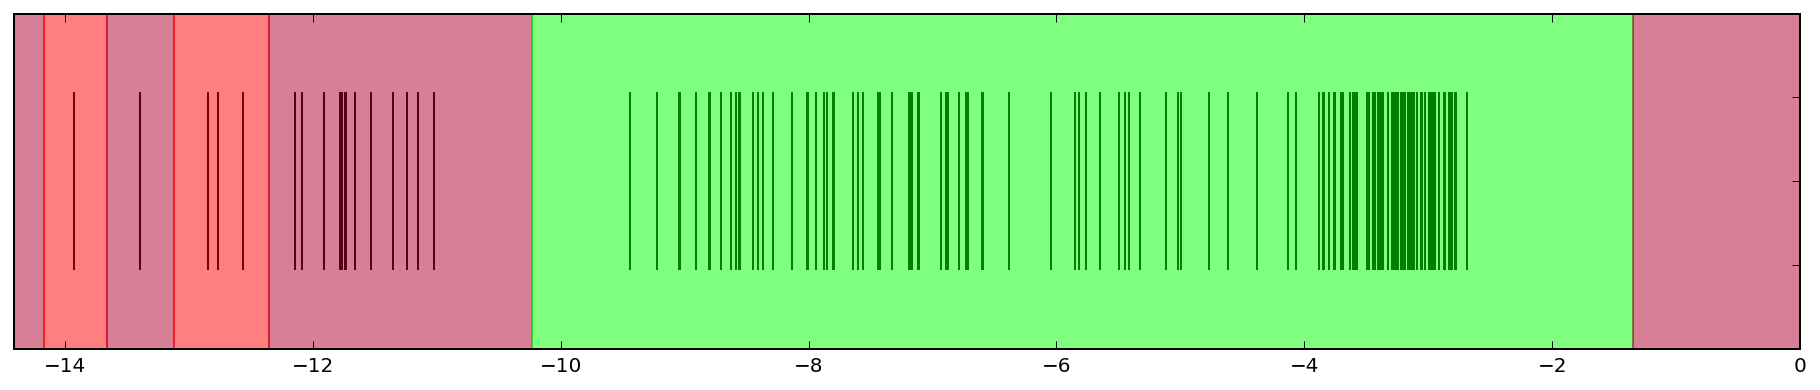

In [9]:
f = exp.apply_threshold(normaly_score, anomaly_score, 6, 1)

In [10]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.95
recall =  0.703703703704
f-measure =  0.808510638298


0.8085106382978724

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.808510638298  (thr =  -9.44225827577 )


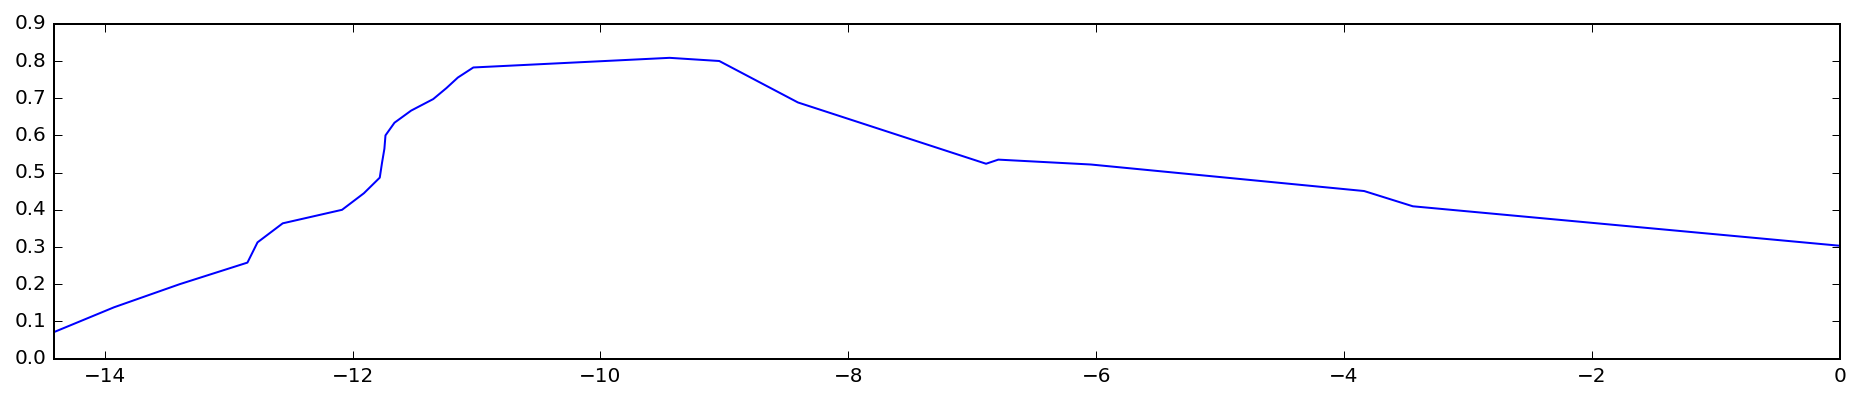

In [11]:
exp.potential_f_measure(normaly_score, anomaly_score)

# ARRHYTHMIA

Что-то медицинское, поэтому я в страхе не стал разбираться, что это. Соотношение количества признаков к количеству объектов более 1/2, также для этого датасета я не нашёл классического разбиения на выборку-тест, поэтому как в голову взбрело разбил. Оригинальная задача - задача классификация, аномальными кластерами считаются не все больные, а только кластера под определёнными номерами

In [12]:
DF = pd.read_csv("arrhythmia.csv", sep=',', header=None)
for c in DF.columns:
    DF[c][DF[c].astype(str) == '?'] = -1
    DF[c] = DF[c].astype(float)
ans = ((DF[279] == 3) | (DF[279] == 4) | (DF[279] == 5) | (DF[279] == 7) | (DF[279] == 8)
       | (DF[279] == 9) | (DF[279] == 14) | (DF[279] == 15))[300:]
del DF[279]

DF, DF_test = DF[:300], DF[300:]
DF

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8
5,13.0,0.0,169.0,51.0,100.0,167.0,321.0,174.0,91.0,107.0,...,0.0,-0.6,12.2,-2.8,0.0,0.0,0.9,2.2,13.5,31.1
6,40.0,1.0,160.0,52.0,77.0,129.0,377.0,133.0,77.0,77.0,...,-0.4,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5
7,49.0,1.0,162.0,54.0,78.0,0.0,376.0,157.0,70.0,67.0,...,-0.3,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8
8,44.0,0.0,168.0,56.0,84.0,118.0,354.0,160.0,63.0,61.0,...,0.1,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9
9,50.0,1.0,167.0,67.0,89.0,130.0,383.0,156.0,73.0,85.0,...,-0.5,-0.6,10.8,-1.7,0.0,0.0,0.8,0.9,20.1,25.1


AUC-ROC score:  0.835861139198


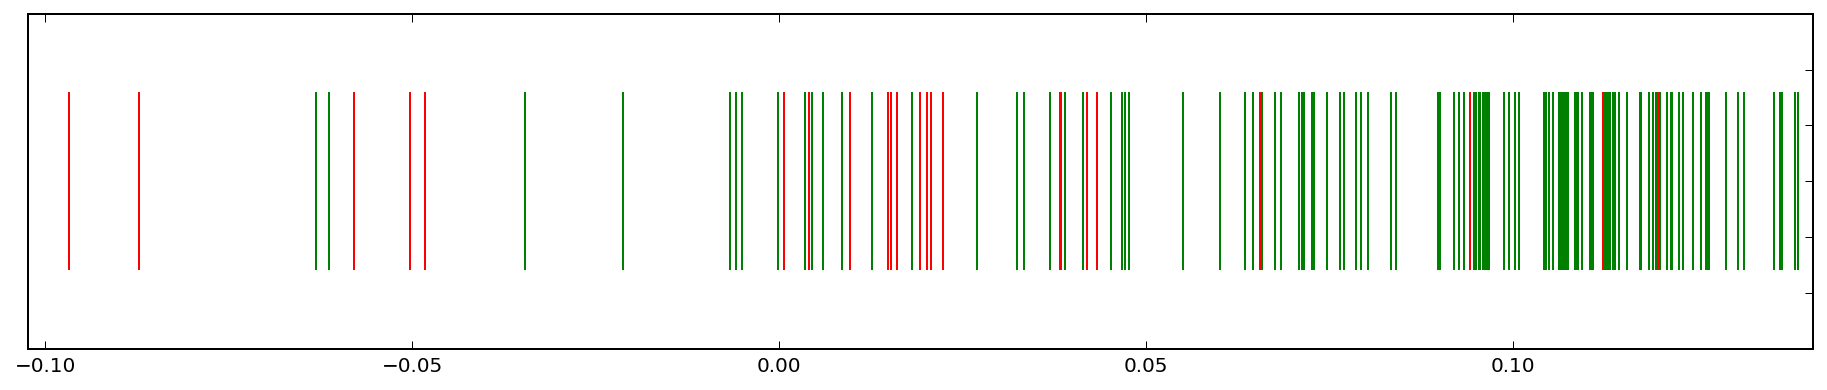

In [29]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.8432760364


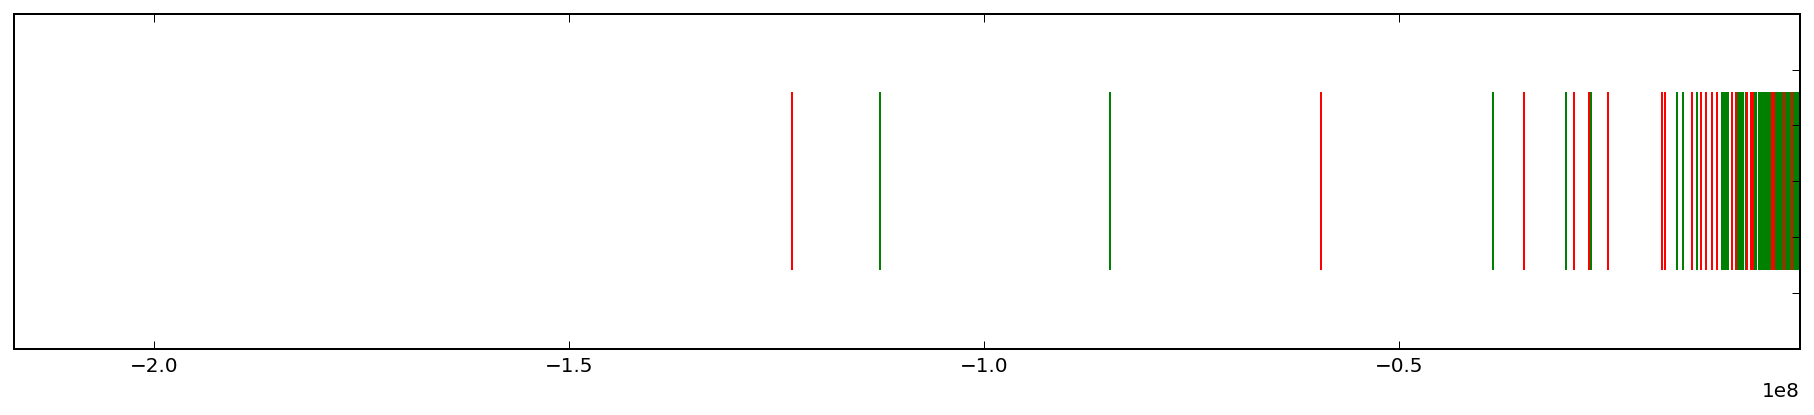

In [20]:
normaly_score, anomaly_score = exp.Solve(exp.PolinomSolver("manhattan"), DF, DF_test[~ans], DF_test[ans])

chebyshev: 0.713683855747

euclidean: 0.798112571621

AUC-ROC score:  0.859453993933


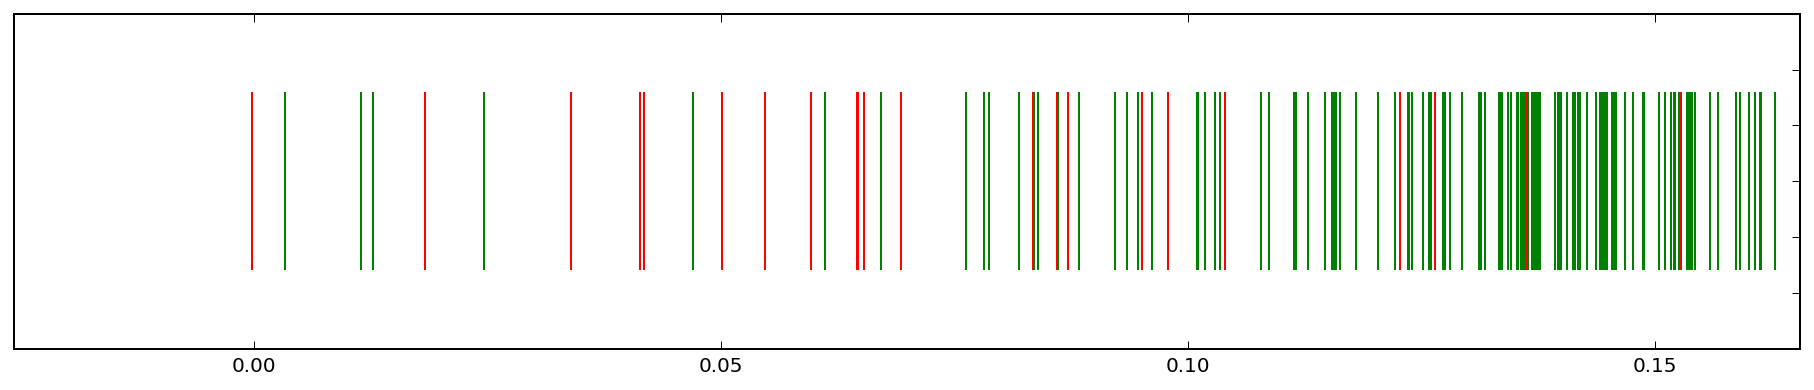

In [13]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

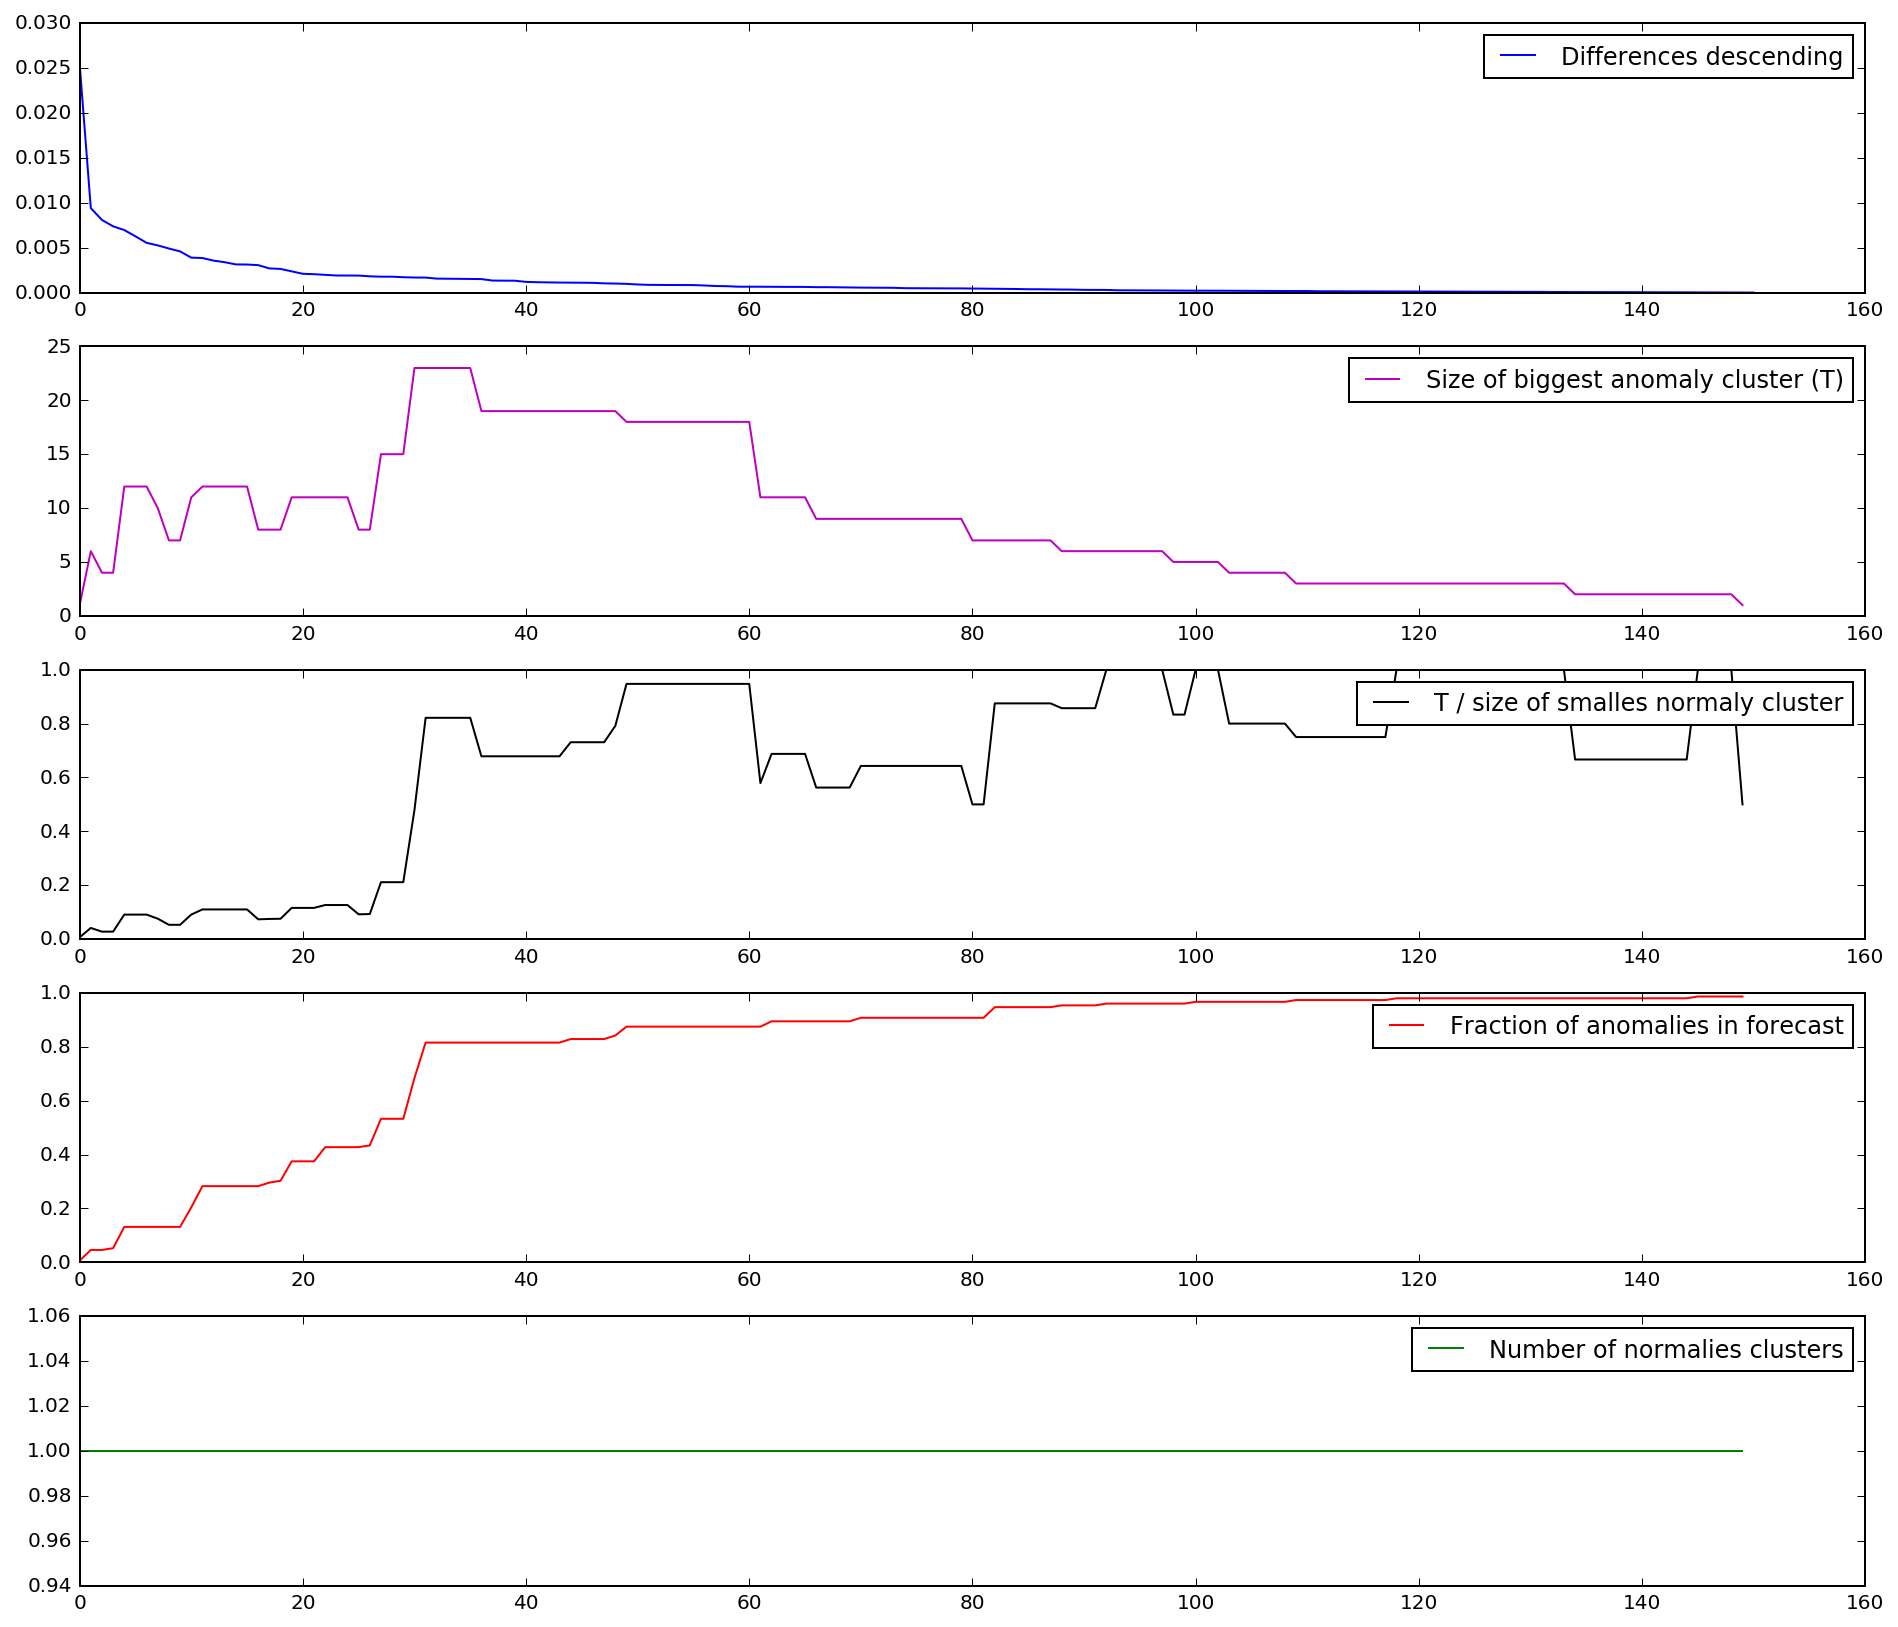

In [14]:
exp.analize_threshold(normaly_score, anomaly_score, -1, 1)

In [16]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

bound variant: n_splits= 27 T =  8 T_frac =  0.093023255814 , anom_frac =  0.434210526316


T =  8
T_frac =  0.093023255814
Anomalies Fraction =  0.434210526316 %


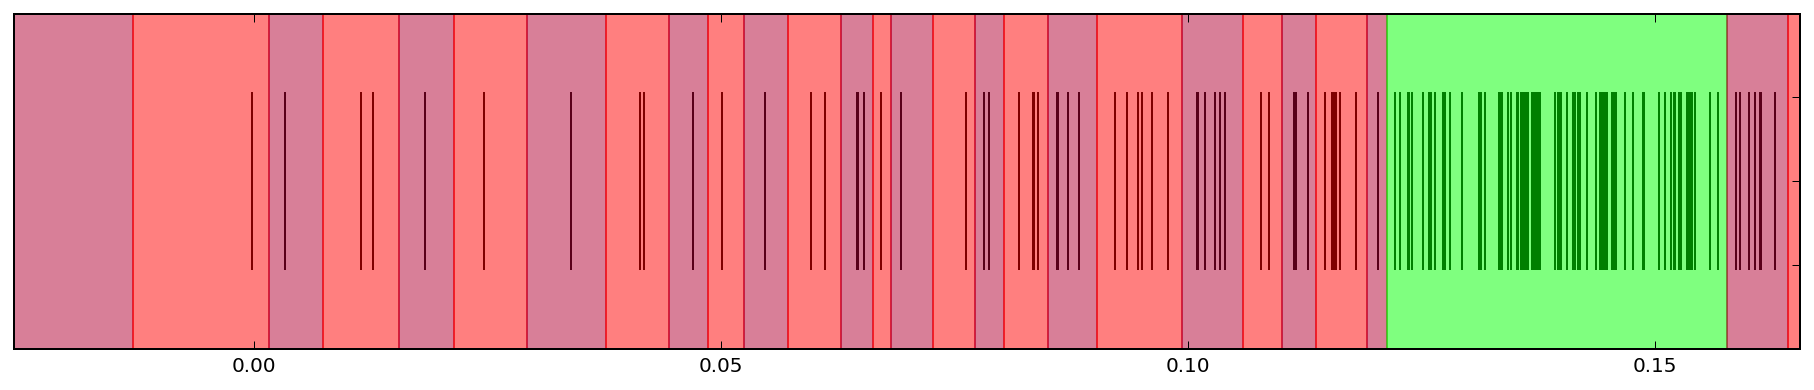

In [30]:
f = exp.apply_threshold(normaly_score, anomaly_score, 27, 1)

In [31]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.287878787879
recall =  0.826086956522
f-measure =  0.426966292135


0.42696629213483145

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.604651162791  (thr =  0.069285261251 )


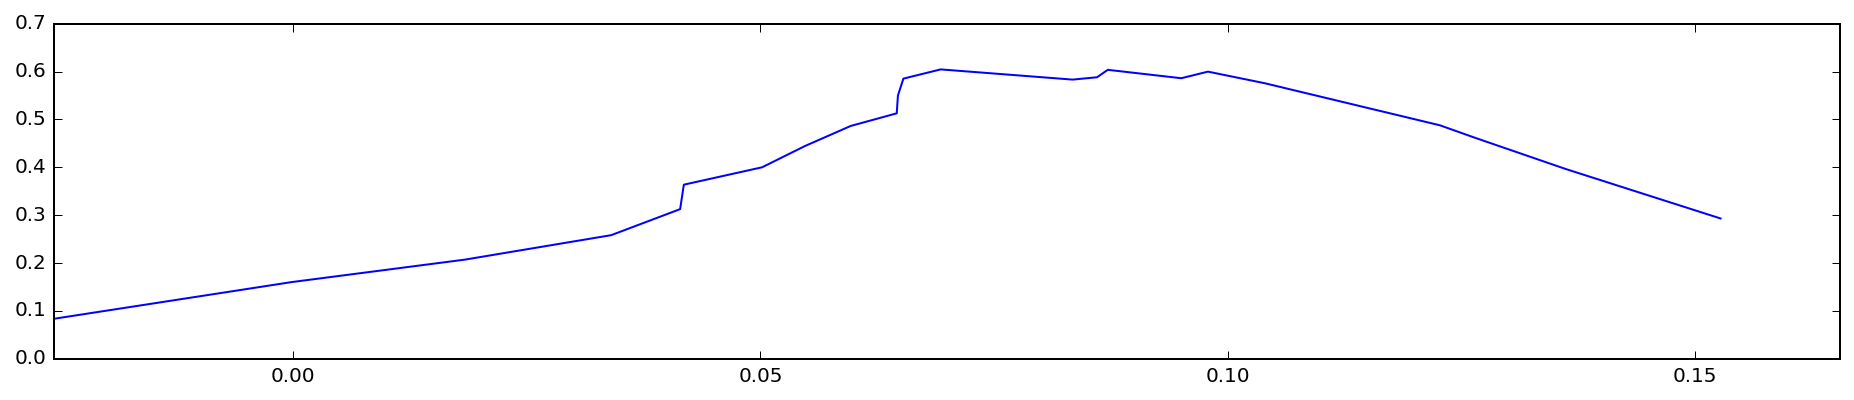

In [20]:
exp.potential_f_measure(normaly_score, anomaly_score)

# BREASTW

опять медицина, да что ж такое-то!
в этот раз речь о диагностике какого-то рака, оригинальный датасет больше, но это какая-то классическая выжимка для задачи бинарной классификации по определнию есть или нет. В оригинале здесь тоже нет классического разбиения на трэйн и тест, но в описании датасета упоминалась кросс-валидация с 10 фолдами

In [32]:
DF = pd.read_csv("breastcw.csv", sep=',', header=None)
for c in DF.columns:
    DF[c][DF[c].astype(str) == '?'] = -10
    DF[c] = DF[c].astype(float)
ans = (DF[10] == 4)[600:]
del DF[10]

DF, DF_test = DF[:600], DF[600:]
DF

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,0,1,2,3,4,5,6,7,8,9
0,1000025.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0
1,1002945.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0
2,1015425.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
3,1016277.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0
4,1017023.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
5,1017122.0,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0
6,1018099.0,1.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0
7,1018561.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0
8,1033078.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0
9,1033078.0,4.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0


AUC-ROC score:  0.603174603175


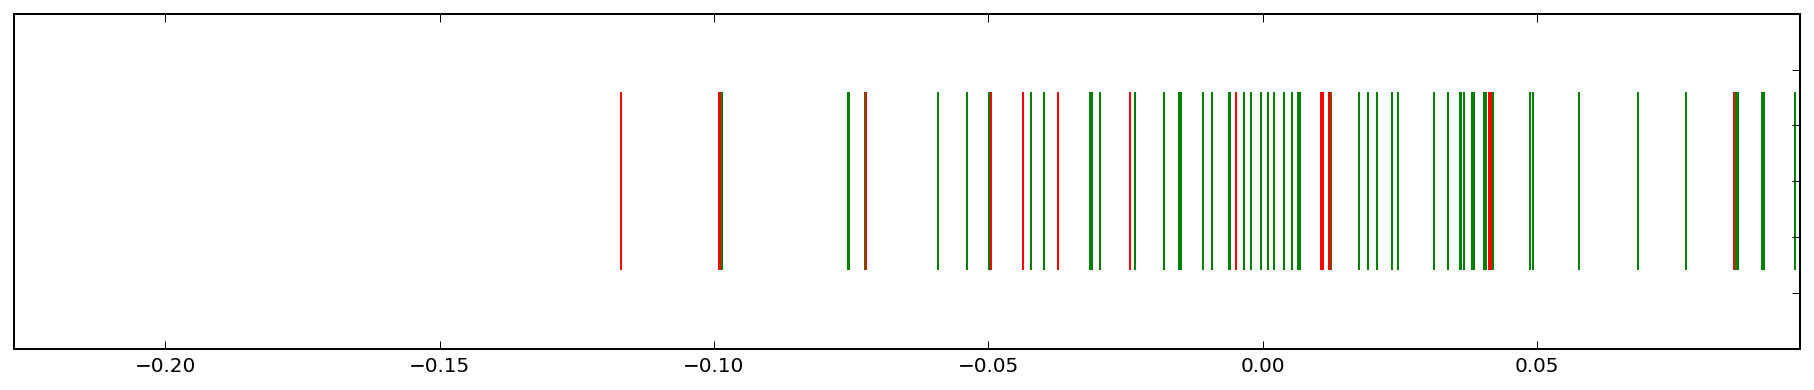

In [57]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.987179487179


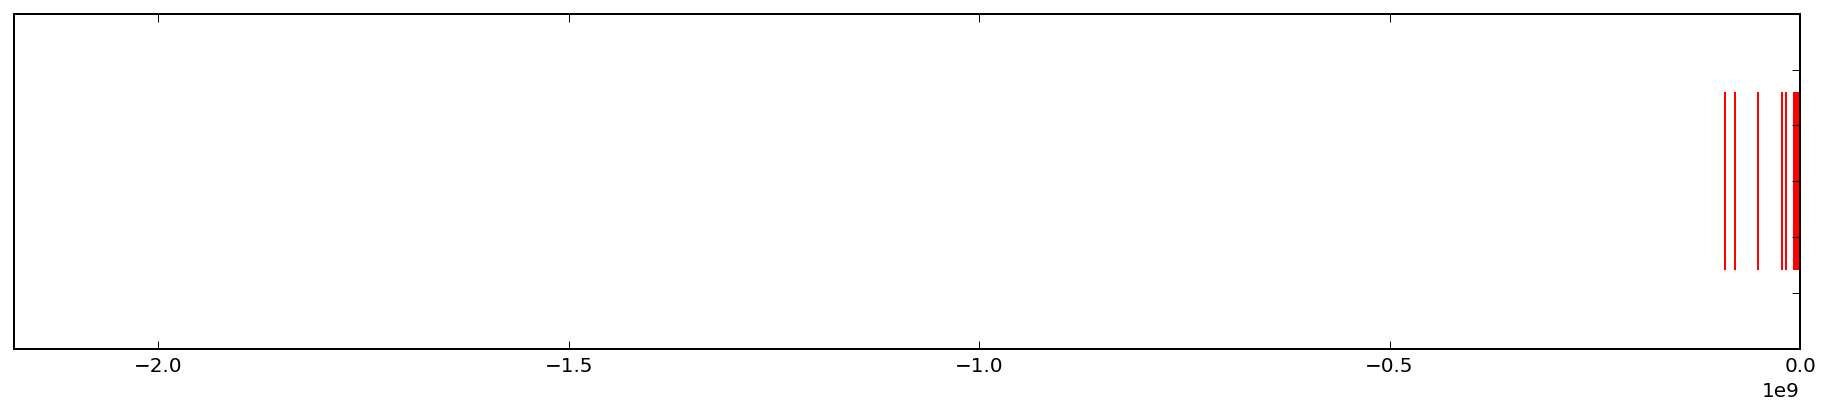

In [38]:
normaly_score, anomaly_score = exp.Solve(exp.PolinomSolver("manhattan"), DF, DF_test[~ans], DF_test[ans])

euclidean: 0.979853479853

chebyshev: 0.96398046398

AUC-ROC score:  1.0


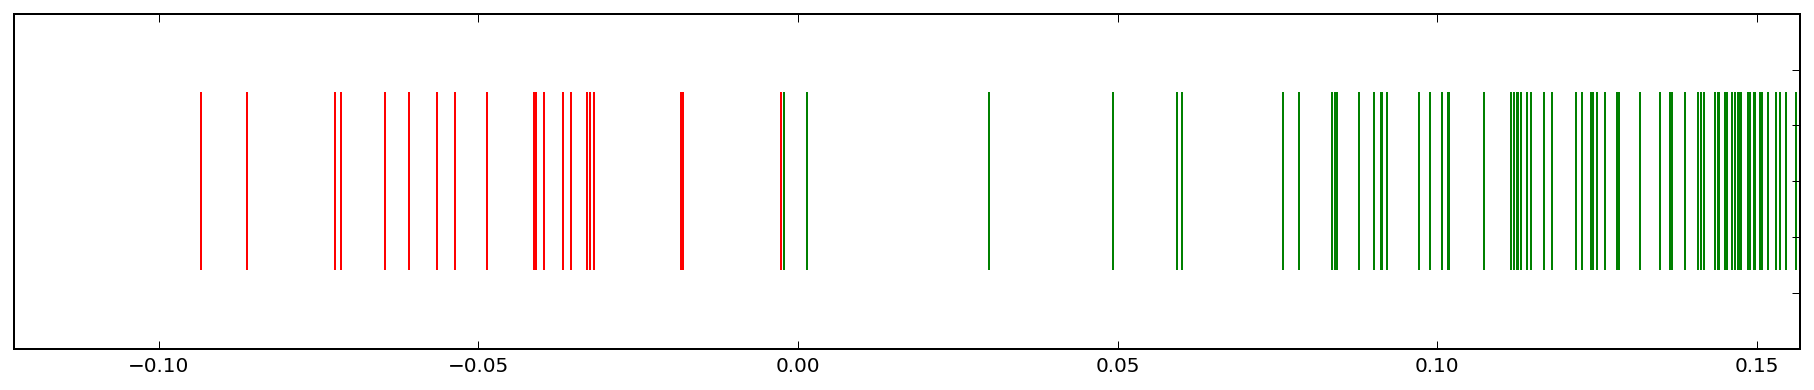

In [39]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

ооооо, что это? стабильный результат))

ооооо, неужели это из-за различия в диапазонах значений, это ж что ж получается, нормировать надо что ли признаки??? мой мир вращается у меня на глазах!

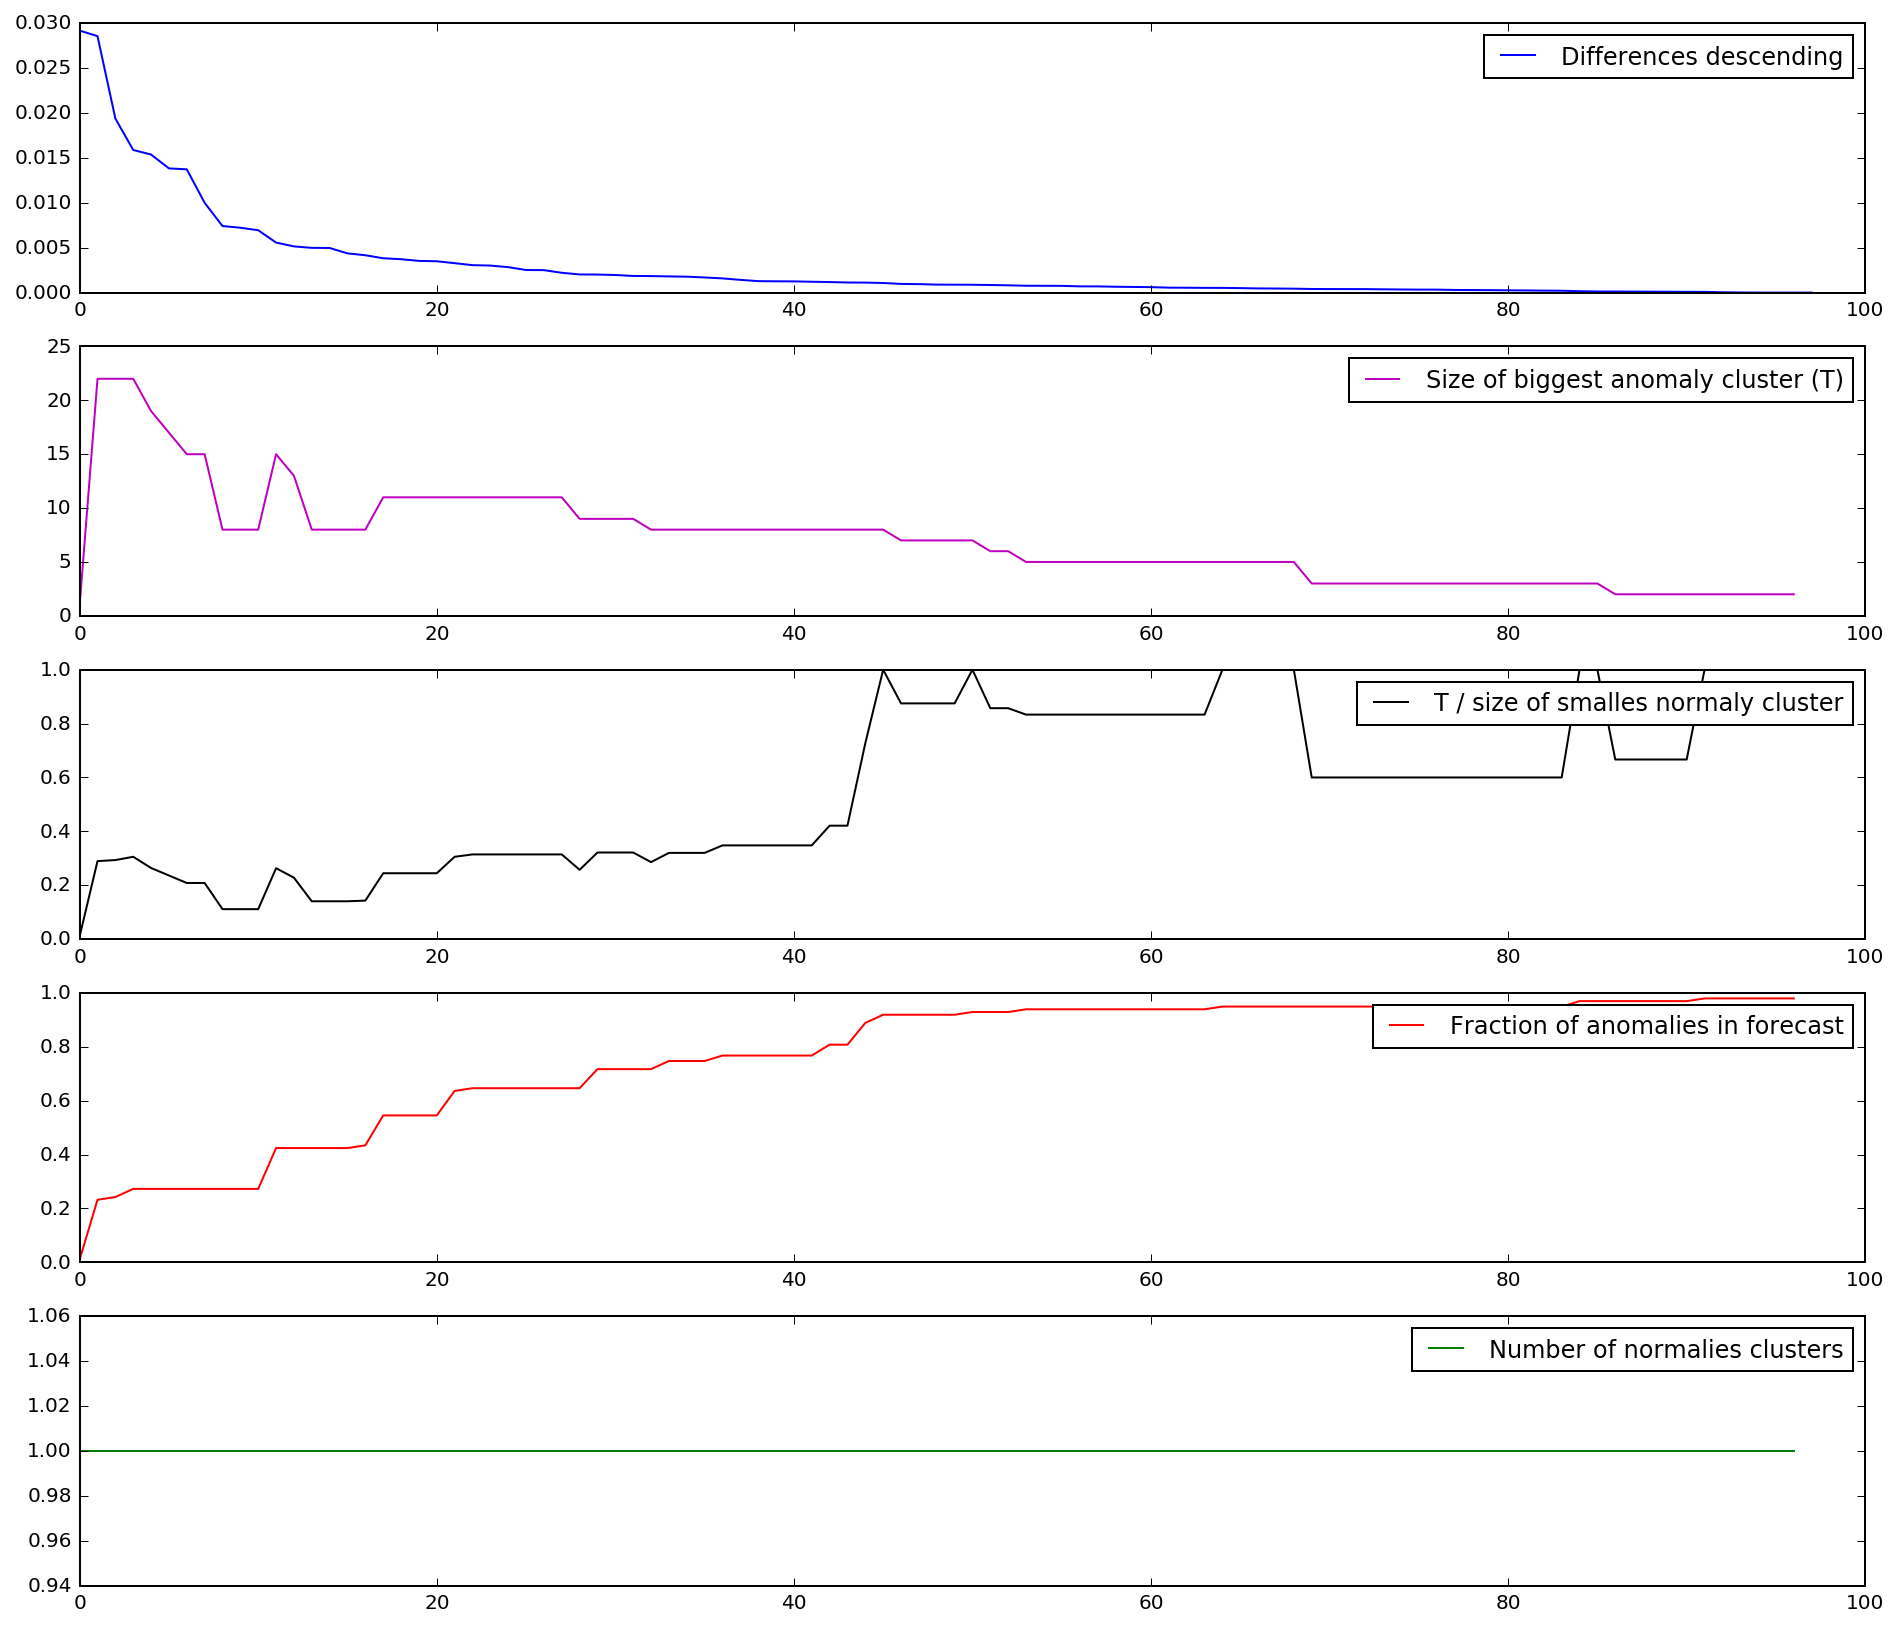

In [40]:
exp.analize_threshold(normaly_score, anomaly_score, -1, 1)

In [41]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

bound variant: n_splits= 17 T =  8 T_frac =  0.142857142857 , anom_frac =  0.434343434343


T =  8
T_frac =  0.142857142857
Anomalies Fraction =  0.434343434343 %


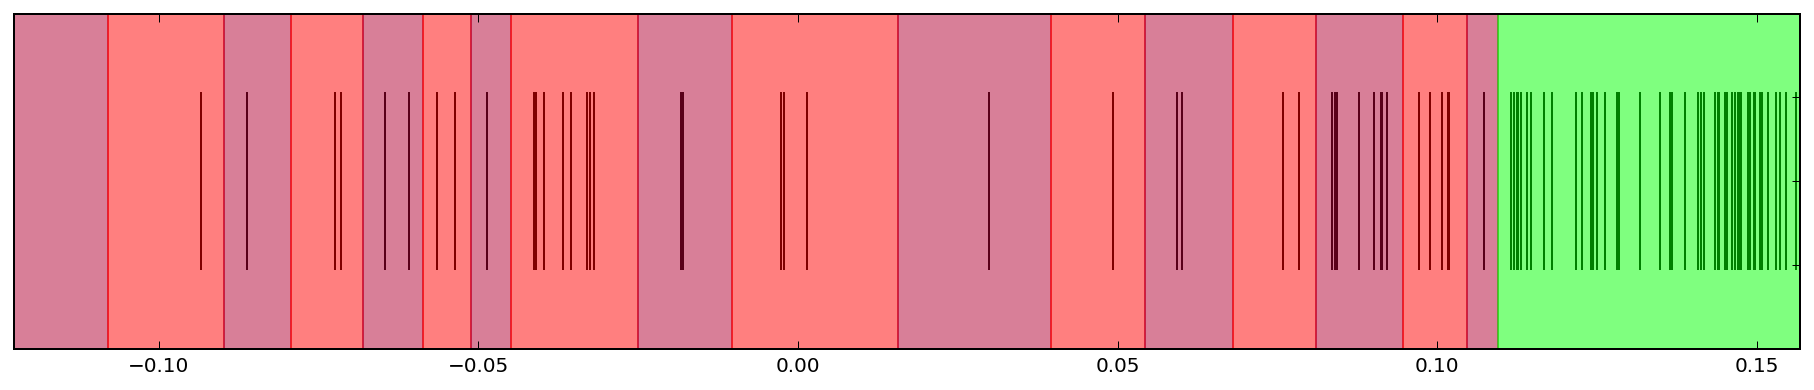

In [42]:
f = exp.apply_threshold(normaly_score, anomaly_score, 17, 1)

In [43]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.488372093023
recall =  1.0
f-measure =  0.65625


0.65625

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  1.0  (thr =  -0.00261214044714 )


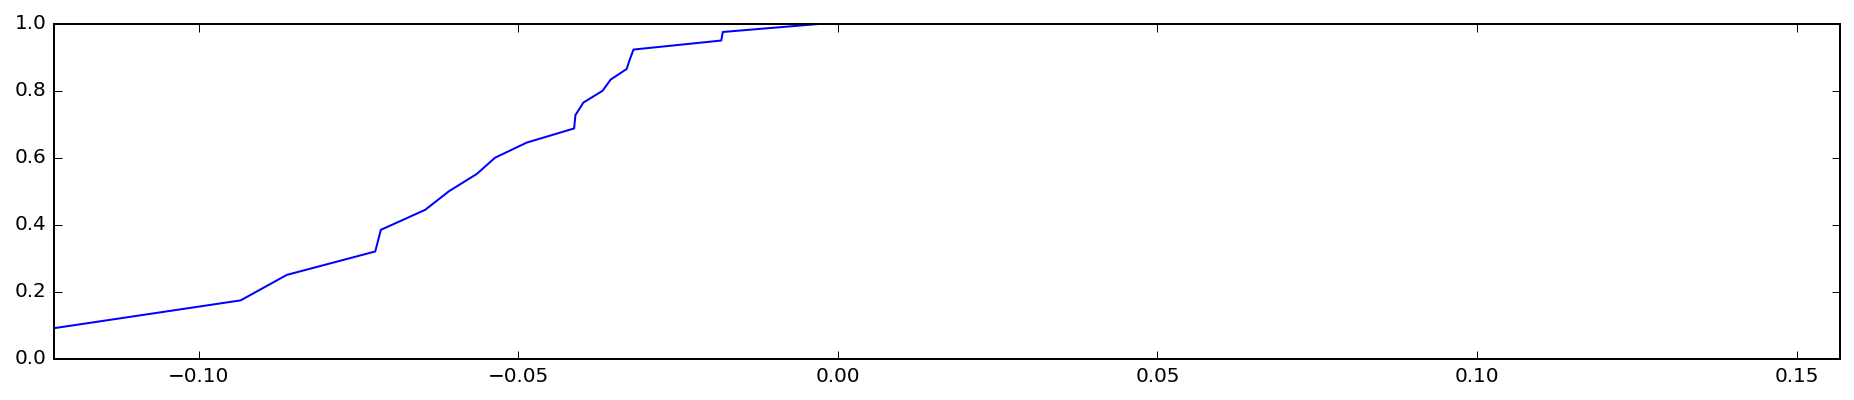

In [44]:
exp.potential_f_measure(normaly_score, anomaly_score)

О, ножницы тоже сломались! Им данных не хватает, боятся резать, когда в кластере нормалий диапазоны и так большие.

# PIMA

да что ж снова-то какой-то диабет!..
-||-, ну разве что тут хотя бы есть классическая теневая выборка

In [45]:
DF = pd.read_csv("pima.csv", sep=',', header=None)
ans = (DF[8] == 1)[576:]
del DF[8]

DF, DF_test = DF[:576], DF[576:]
DF

,0,1,2,3,4,5,6,7
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
6,3,78,50,32,88,31.0,0.248,26
7,10,115,0,0,0,35.3,0.134,29
8,2,197,70,45,543,30.5,0.158,53
9,8,125,96,0,0,0.0,0.232,54


AUC-ROC score:  0.652576112412


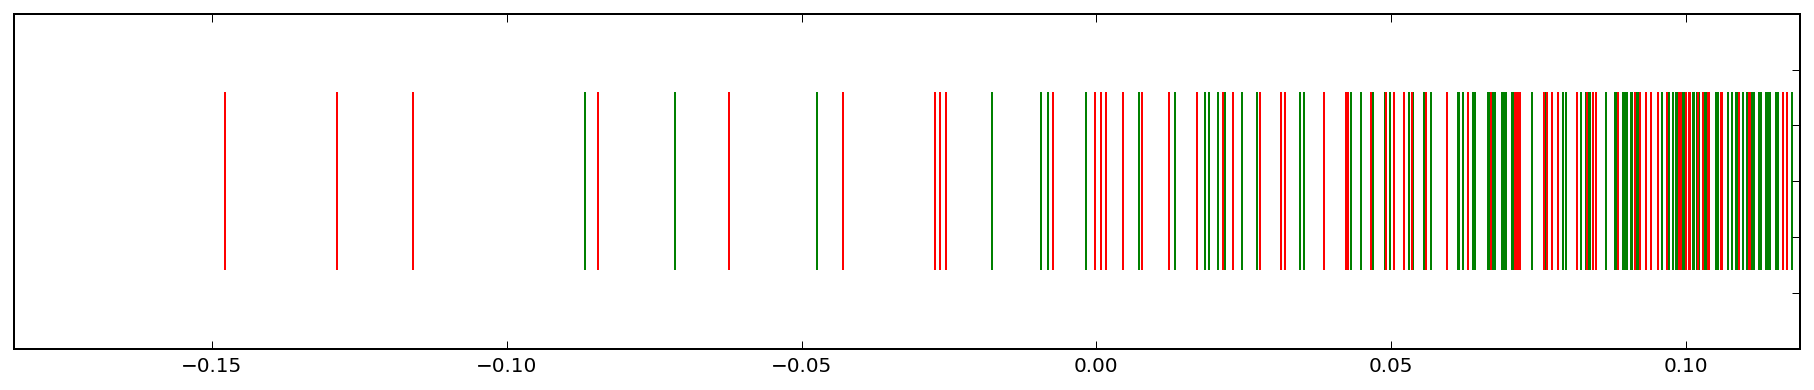

In [70]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.724590163934


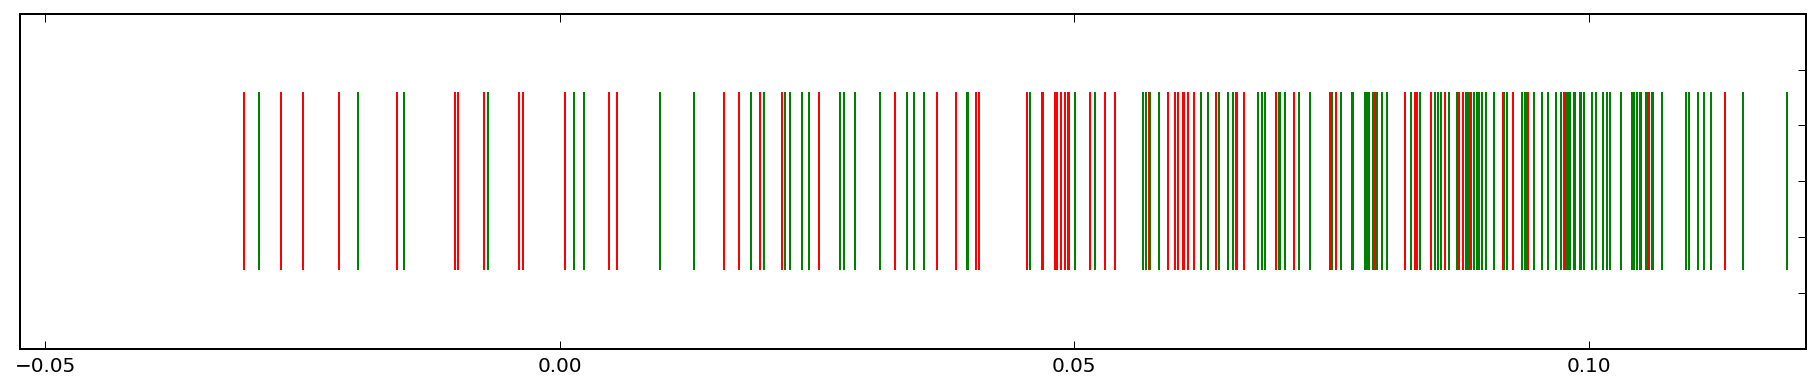

In [69]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.73606557377


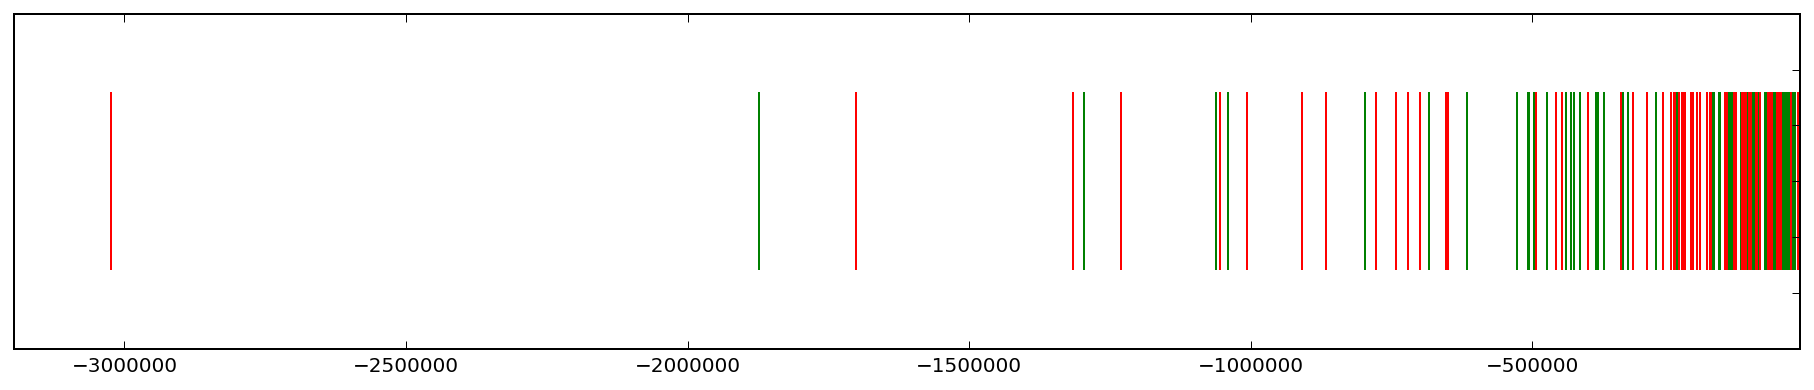

In [49]:
normaly_score, anomaly_score = exp.Solve(exp.PolinomSolver("manhattan"), DF, DF_test[~ans], DF_test[ans])

chebyshev: 0.727283372365 

euclidean: 0.735362997658

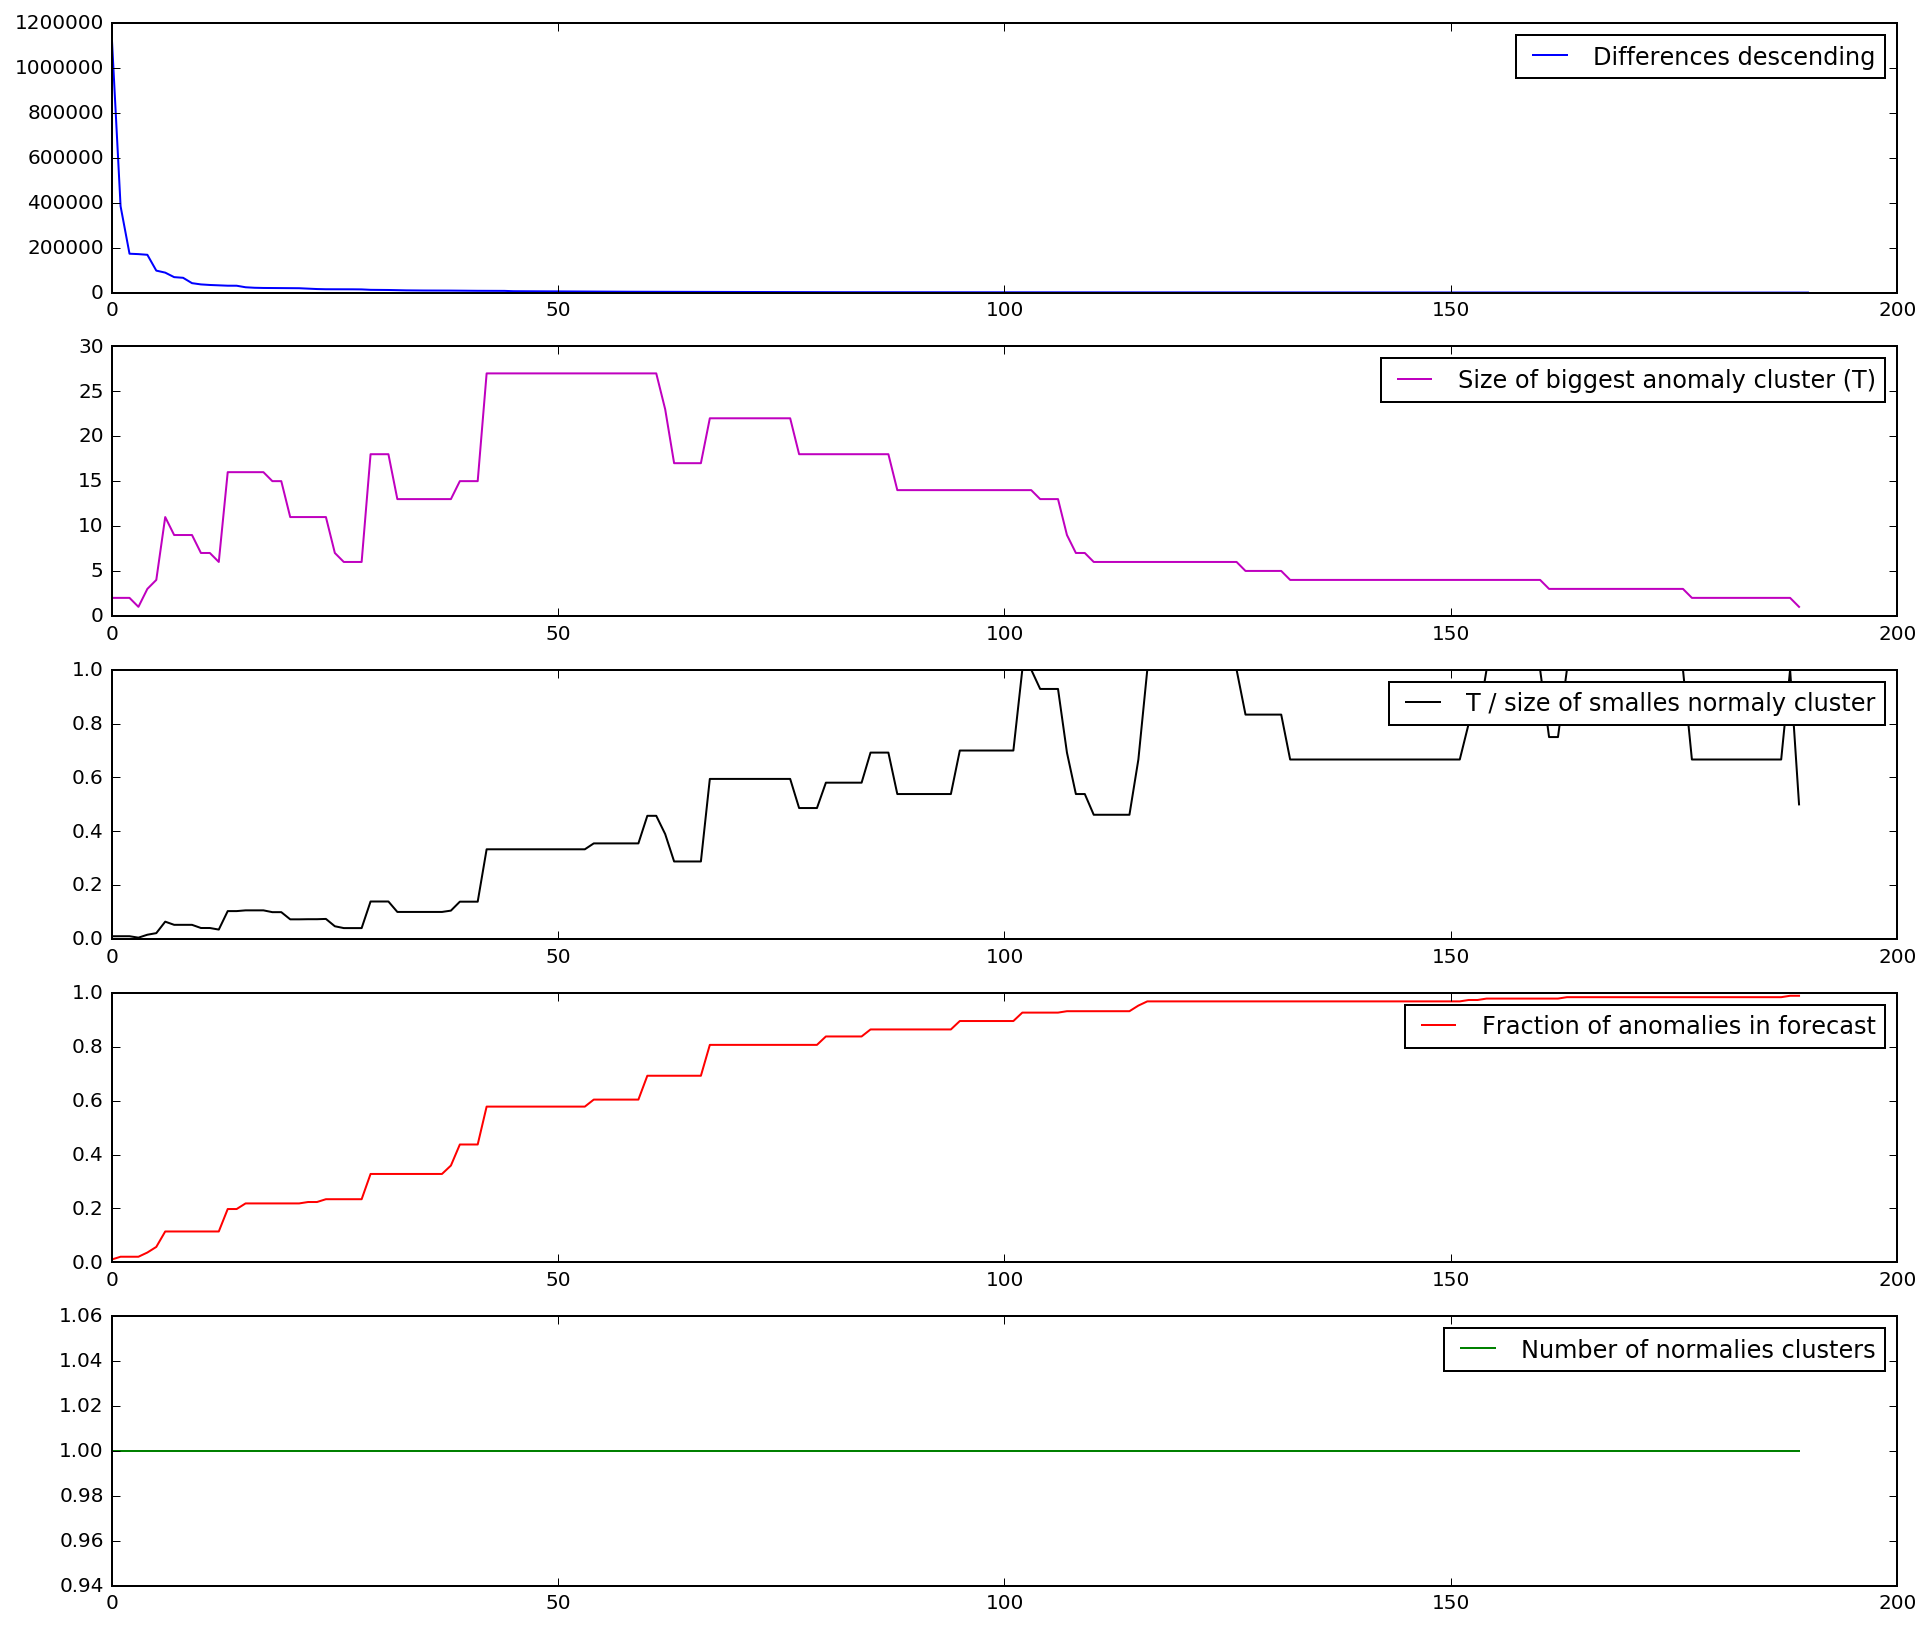

In [51]:
exp.analize_threshold(normaly_score, anomaly_score, -1, 1)

In [52]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

bound variant: n_splits= 42 T =  15 T_frac =  0.138888888889 , anom_frac =  0.4375


T =  15
T_frac =  0.138888888889
Anomalies Fraction =  0.4375 %


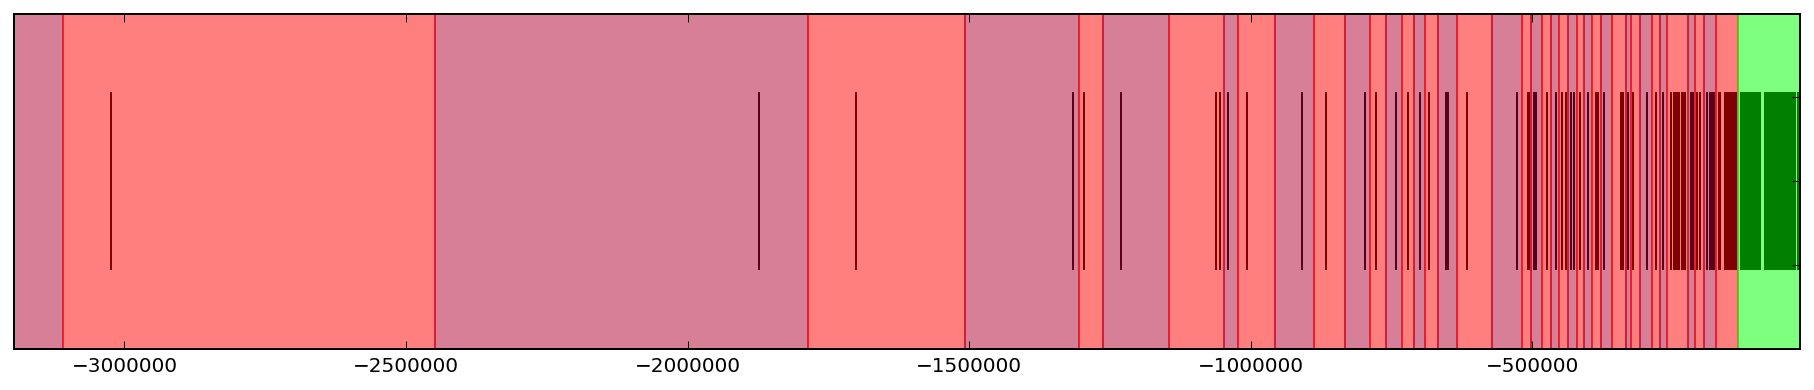

In [53]:
f = exp.apply_threshold(normaly_score, anomaly_score, 42)

In [54]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.559523809524
recall =  0.671428571429
f-measure =  0.61038961039


0.61038961038961037

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.638554216867  (thr =  -112159.128526 )


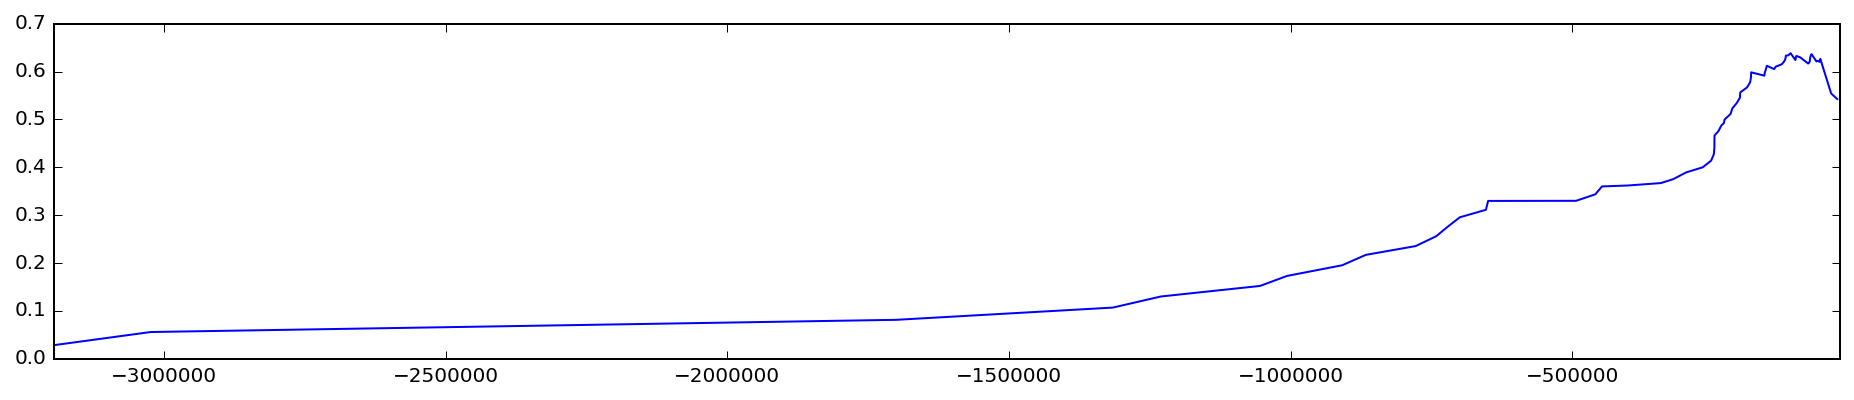

In [55]:
exp.potential_f_measure(normaly_score, anomaly_score)

# SATTELITE

Вот, дивный датасет! Космические снимки! Со спутника!
Датасет, по заявкам, небольшой кусок картинки космического снимка. Для каждого пикселя даны значения 4 каналов (два инфракрасных канала, зелёный спектр, красный спектр) для него и для 8 его соседей. Всё перемешано и что-то убрано, чтобы нельзя было восстановить оригинальное изображение. Требуется определить, что сфотографировано "в этом пикселе".

In [57]:
DF = pd.read_csv("satellite.csv", sep=';', header=None)
del DF[36]
DF

DF_test = pd.read_csv("satellite_test.csv", sep=';', header=None)
ans = (DF_test[36] == 2) | (DF_test[36] == 4) | (DF_test[36] == 5)
del DF_test[36]
DF

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,92,115,120,94,84,102,106,79,84,102,...,134,104,88,121,128,100,84,107,113,87
1,84,102,106,79,84,102,102,83,80,102,...,128,100,84,107,113,87,84,99,104,79
2,84,102,102,83,80,102,102,79,84,94,...,113,87,84,99,104,79,84,99,104,79
3,80,102,102,79,84,94,102,79,80,94,...,104,79,84,99,104,79,84,103,104,79
4,84,94,102,79,80,94,98,76,80,102,...,104,79,84,103,104,79,79,107,109,87
5,80,94,98,76,80,102,102,79,76,102,...,104,79,79,107,109,87,79,107,109,87
6,76,102,106,83,76,102,106,87,80,98,...,113,87,79,103,104,83,79,103,104,79
7,76,102,106,87,80,98,106,79,76,94,...,104,83,79,103,104,79,79,95,100,79
8,76,89,98,76,76,94,98,76,76,98,...,96,75,75,91,96,71,79,87,93,71
9,76,94,98,76,76,98,102,72,76,94,...,96,71,79,87,93,71,79,87,93,67


AUC-ROC score:  0.645124022877


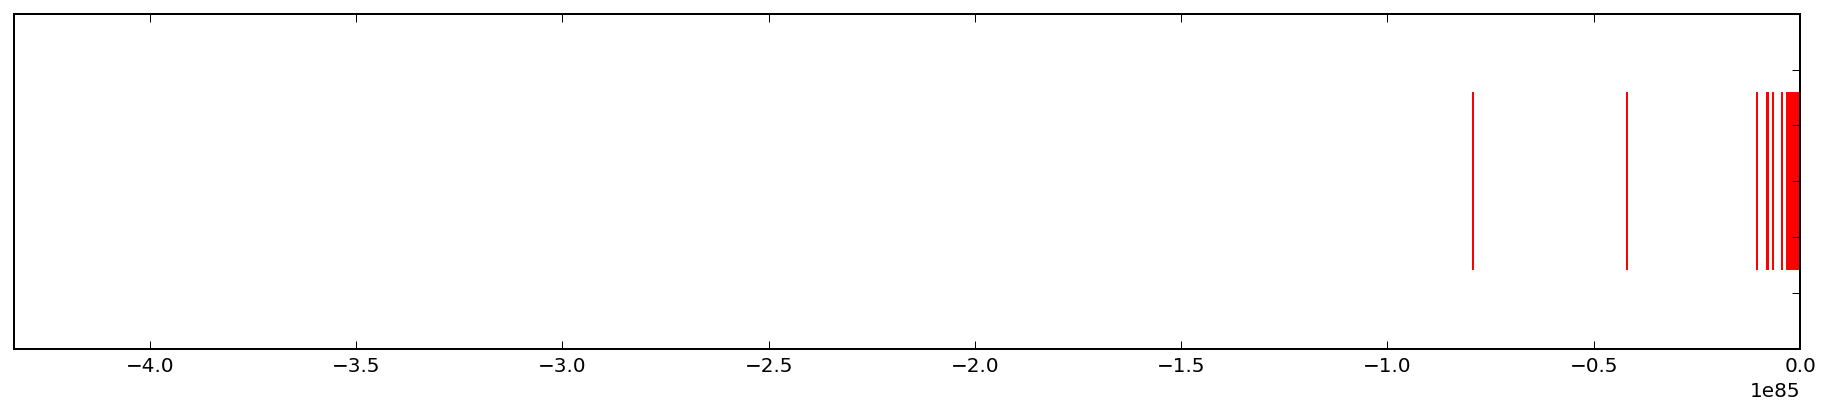

In [61]:
normaly_score, anomaly_score = exp.Solve(exp.PolinomSolver("manhattan"), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.697358630952


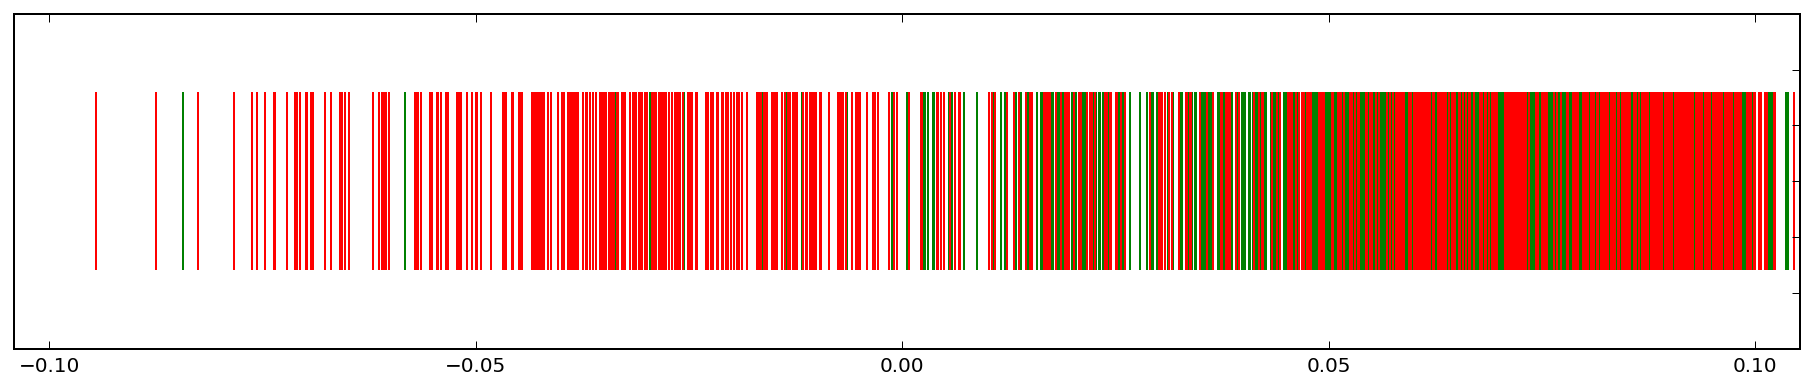

In [5]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.700800971744


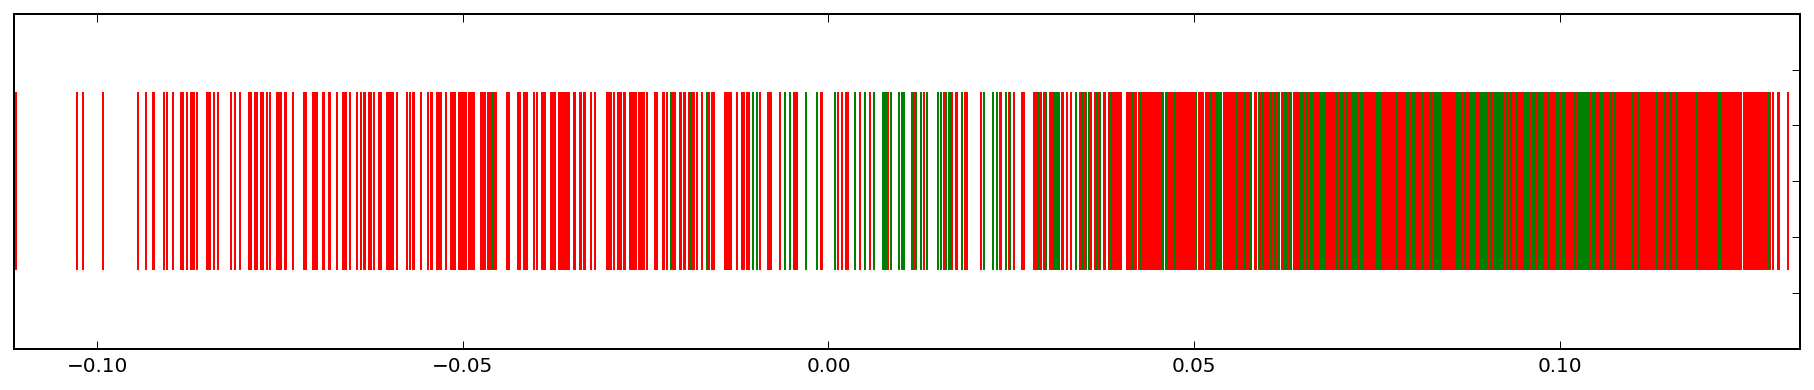

In [62]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

euclidean: 0.641348877653

chebyshev: 0.63036409029

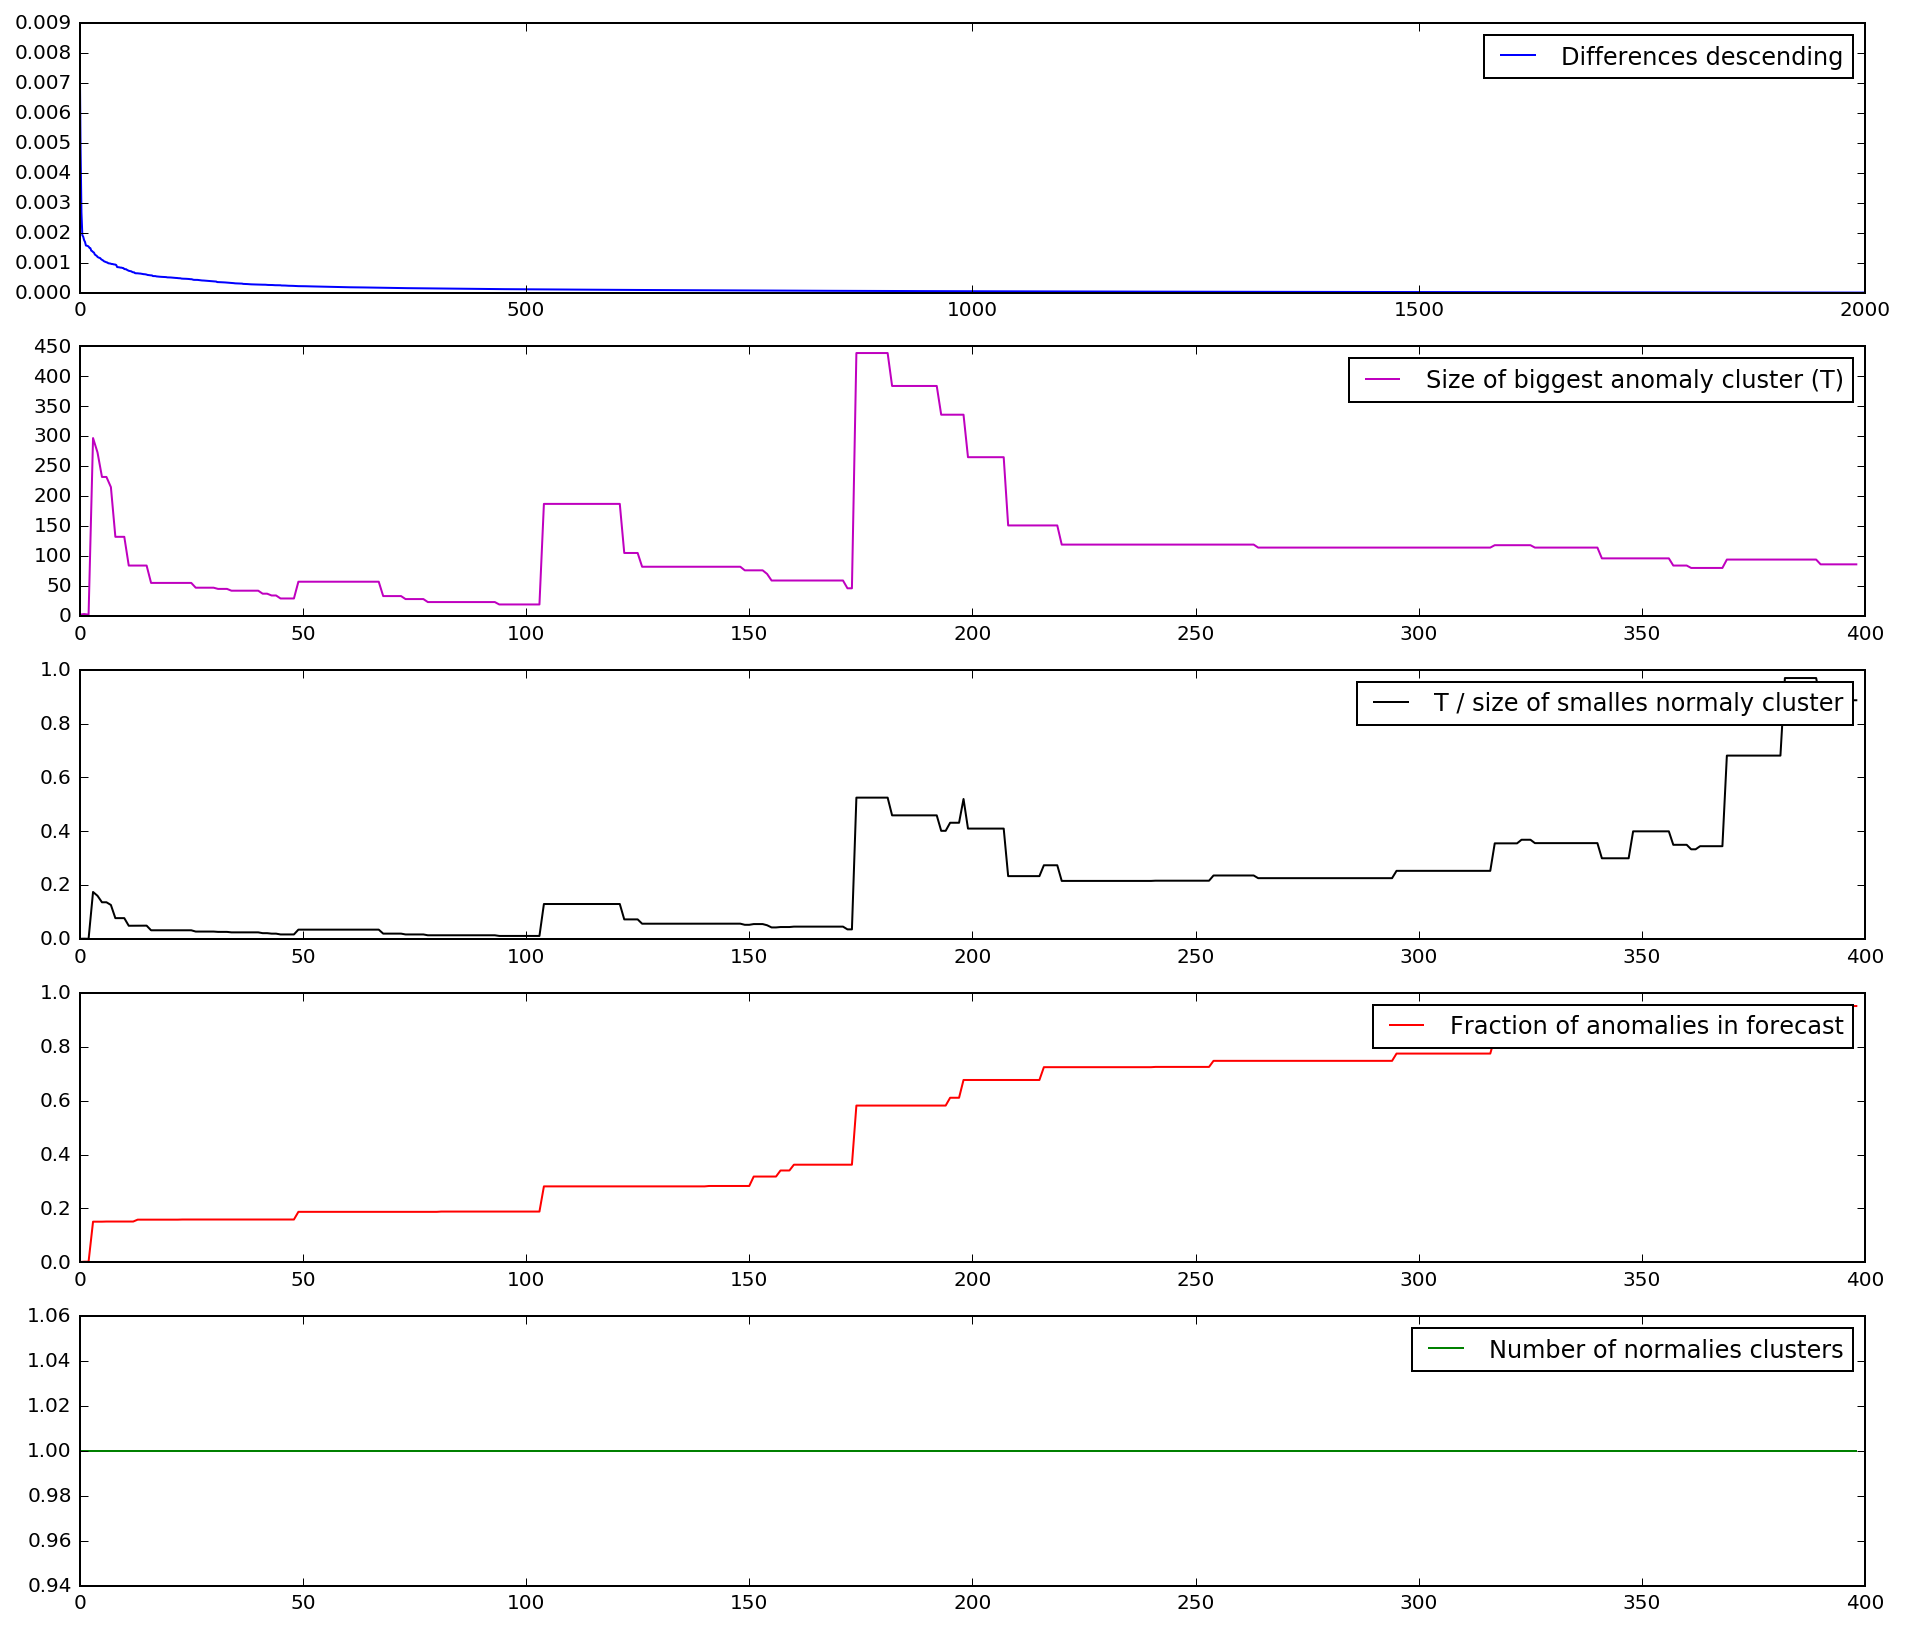

In [64]:
exp.analize_threshold(normaly_score, anomaly_score, 400, 1)

Известно, что anomaly_fraction на самом деле ~ 0.33333.

In [65]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

bound variant: n_splits= 174 T =  46 T_frac =  0.0360784313725 , anom_frac =  0.3625


вот просто отлично, что это bound variant - это означает, что ещё одно разбиение, и доля аномалий в предсказании превысит 0.5, что заведомо неправильно. А 0.36 - отлично.

T =  46
T_frac =  0.0360784313725
Anomalies Fraction =  0.3625 %


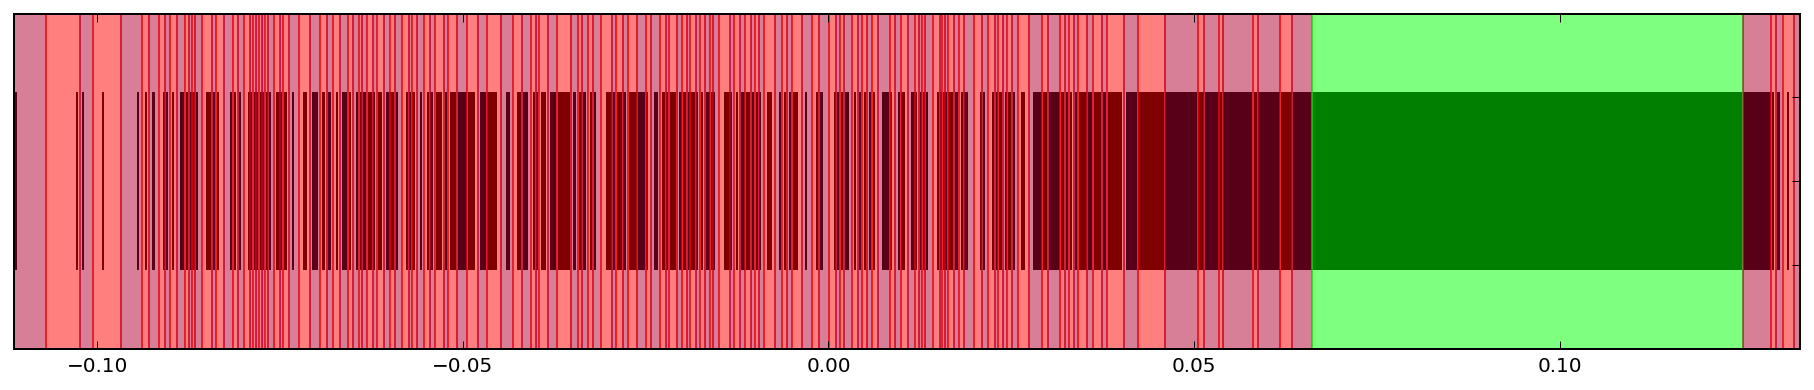

In [66]:
f = exp.apply_threshold(normaly_score, anomaly_score, 174, 1)

In [67]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.60275862069
recall =  0.650297619048
f-measure =  0.625626342162


0.62562634216177526

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.61277283751  (thr =  0.0585195936724 )


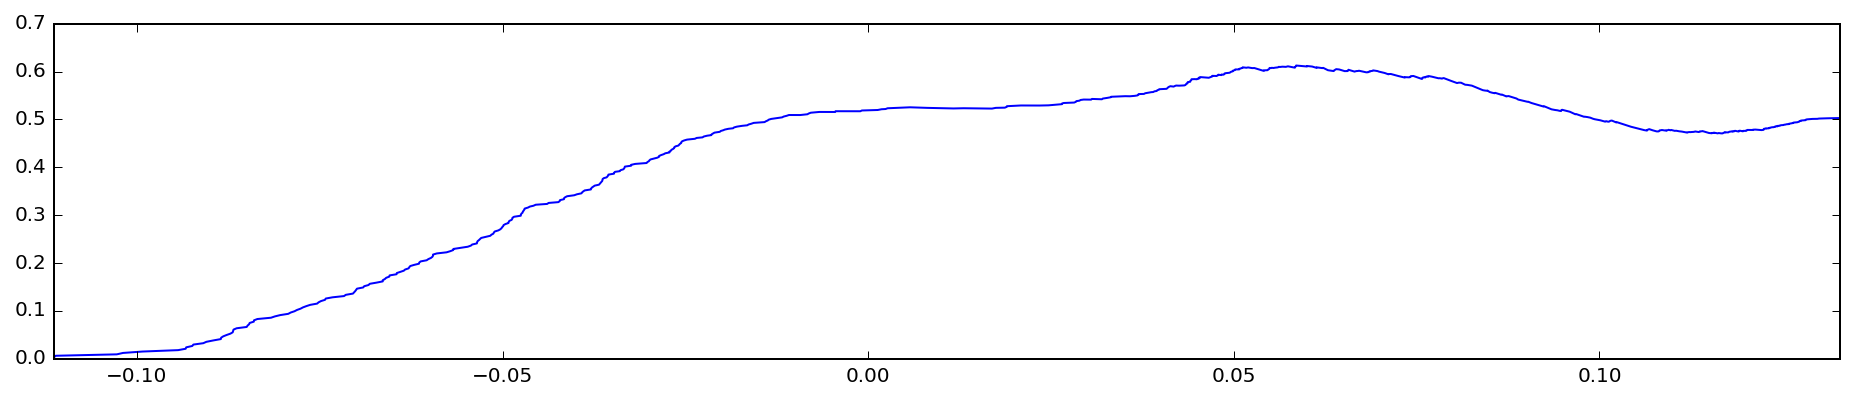

In [68]:
exp.potential_f_measure(normaly_score, anomaly_score)

о_О, точки с высоким anomaly_score что ли на самом деле аномалии? как это так вообще?

# THYROID

и опять...
по этой болезни датасетов в базе много и они намешаны, для аномалий использовался, похоже что, именно эта версия датасета. На теневой столько же объектов, сколько и на обучающей; нет пропущенных значений, которые в прошлых маленьких датасетишках я костыльно забивал -1.

Кстати. Интересный момент. В оригинальном датасете есть ещё 15 бинарных признаков. Если их оставить, лес выдаёт результат около 0.6, когда же без них - около 0.8. Действительно, логично - лесу не нравятся бинарные признаки...

In [69]:
DF = pd.read_csv("ann-train.csv", sep=' ', header=None)
del DF[22]
del DF[23]
del DF[21]
for i in range(1, 16):
    del DF[i]

DF_test = pd.read_csv("ann-test.csv", sep=' ', header=None)
ans = (DF_test[21] == 1) | (DF_test[21] == 2)
del DF_test[21]
del DF_test[22]
del DF_test[23]
for i in range(1, 16):
    del DF_test[i]
DF

,0,16,17,18,19,20
0,0.73,0.00060,0.0150,0.120,0.082,0.146
1,0.24,0.00025,0.0300,0.143,0.133,0.108
2,0.47,0.00190,0.0240,0.102,0.131,0.078
3,0.64,0.00090,0.0170,0.077,0.090,0.085
4,0.23,0.00025,0.0260,0.139,0.090,0.153
5,0.69,0.00025,0.0160,0.086,0.070,0.123
6,0.85,0.00025,0.0230,0.128,0.104,0.121
7,0.48,0.00208,0.0200,0.086,0.078,0.110
8,0.67,0.00130,0.0240,0.087,0.109,0.080
9,0.76,0.00010,0.0290,0.124,0.128,0.097


AUC-ROC score:  0.598996853367


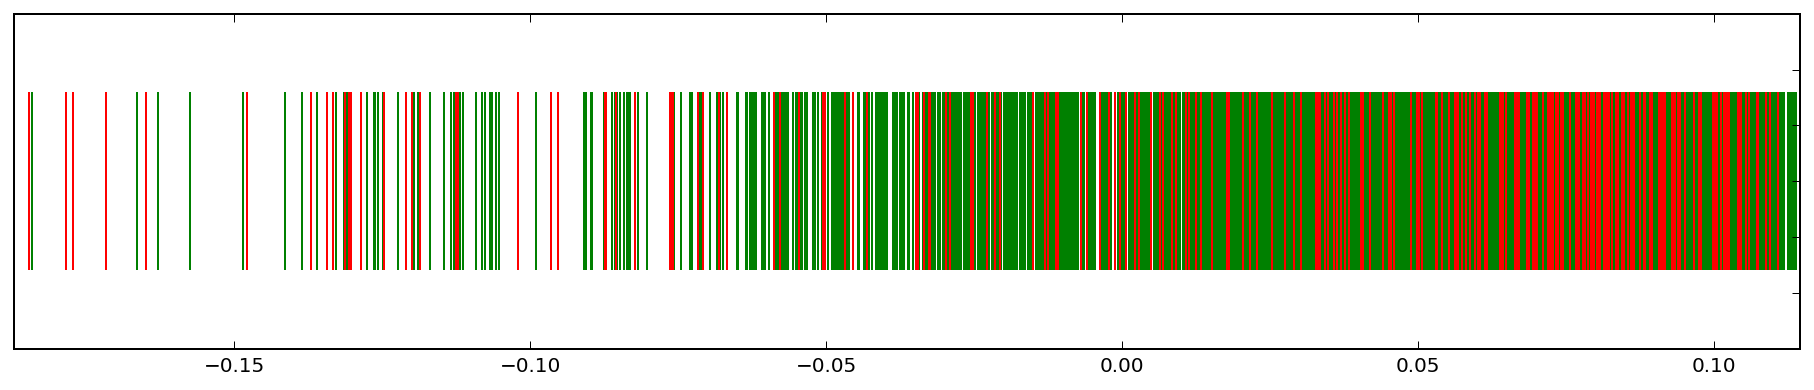

In [116]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.676531151668


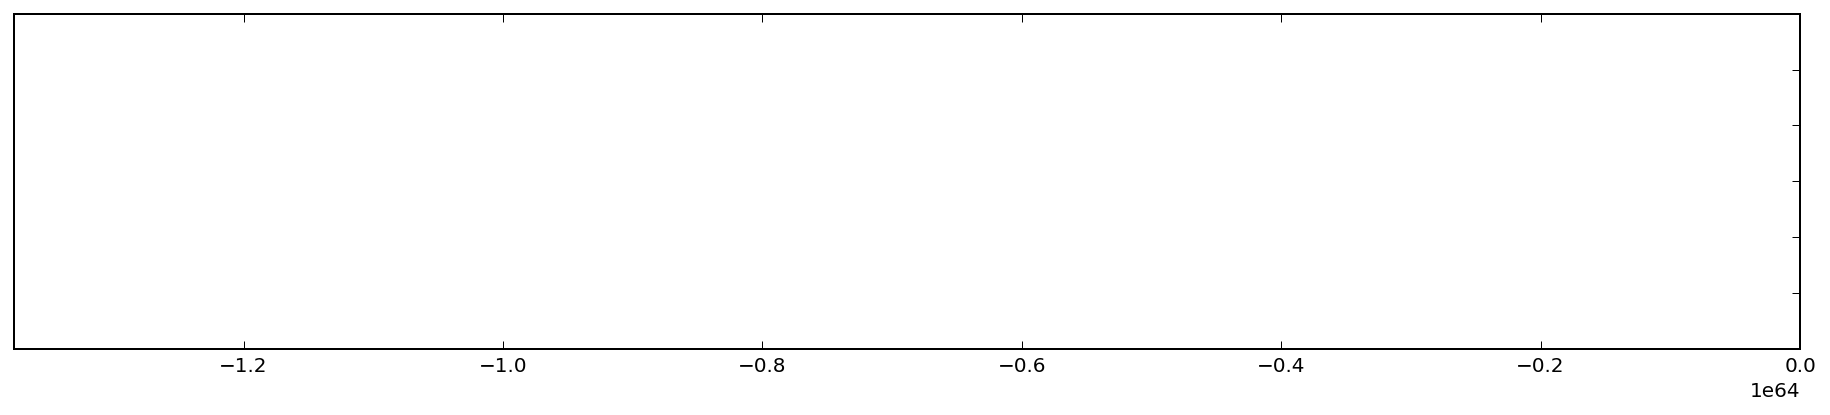

In [73]:
normaly_score, anomaly_score = exp.Solve(exp.PolinomSolver("manhattan"), DF, DF_test[~ans], DF_test[ans])

chebyshev: 0.578185022026

euclidean: 0.618375078666

AUC-ROC score:  0.780343612335


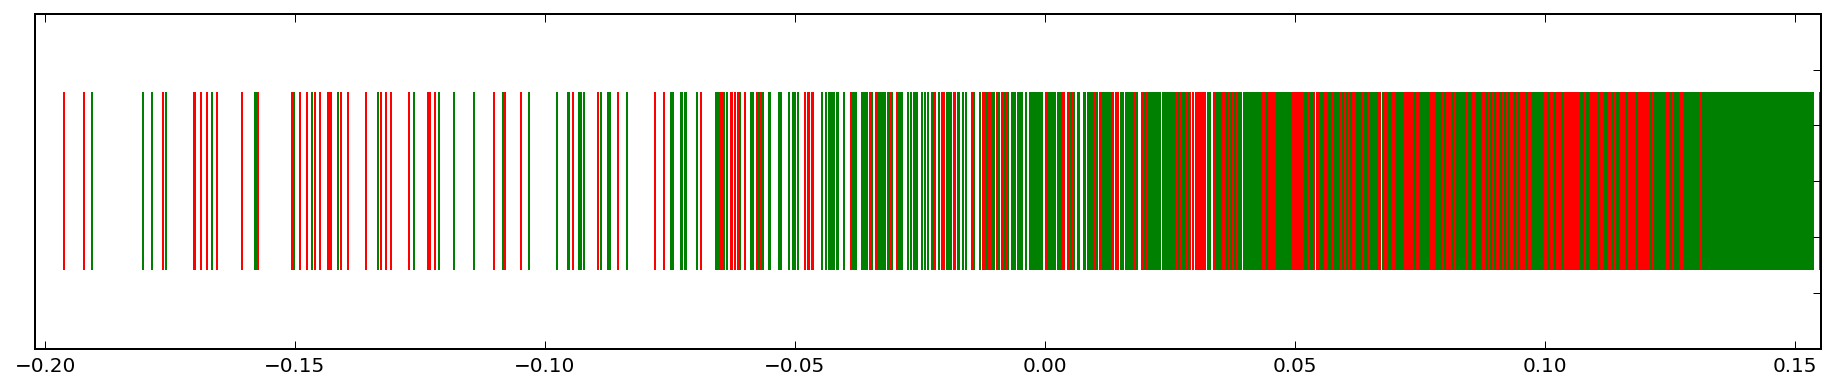

In [117]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

такс, пора доставать стандарт скэйлер!

In [118]:
for c in DF.columns:
    DF_test[c] = (DF_test[c] - DF[c].min()) / (DF[c].max() - DF[c].min())
    DF[c] = (DF[c] - DF[c].min()) / (DF[c].max() - DF[c].min())

AUC-ROC score:  0.58445814978


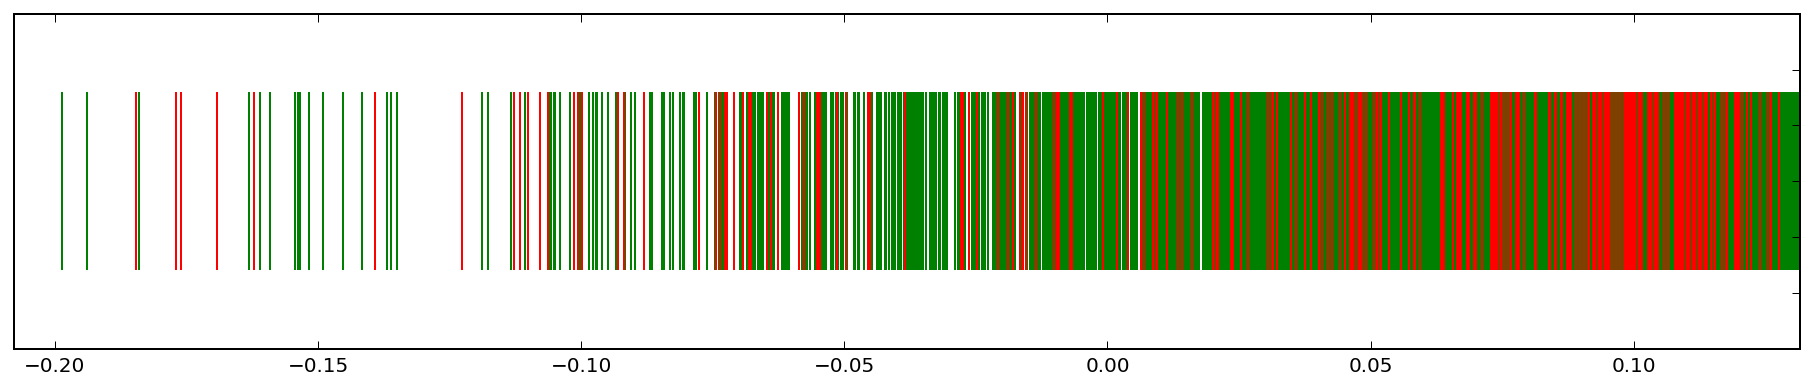

In [119]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.789308999371


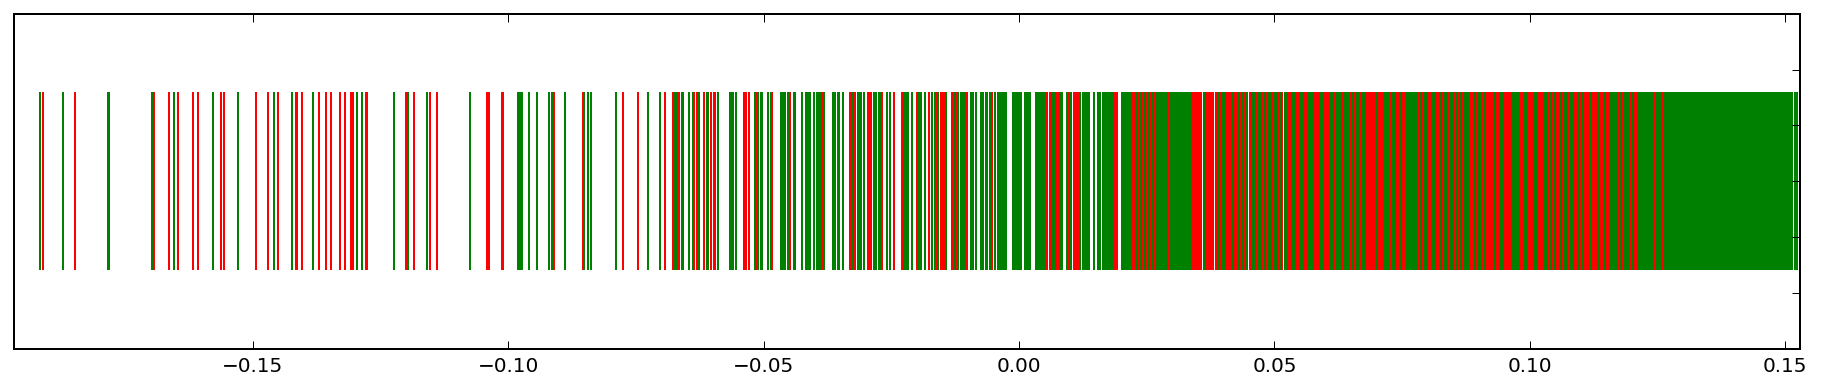

In [74]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

:/

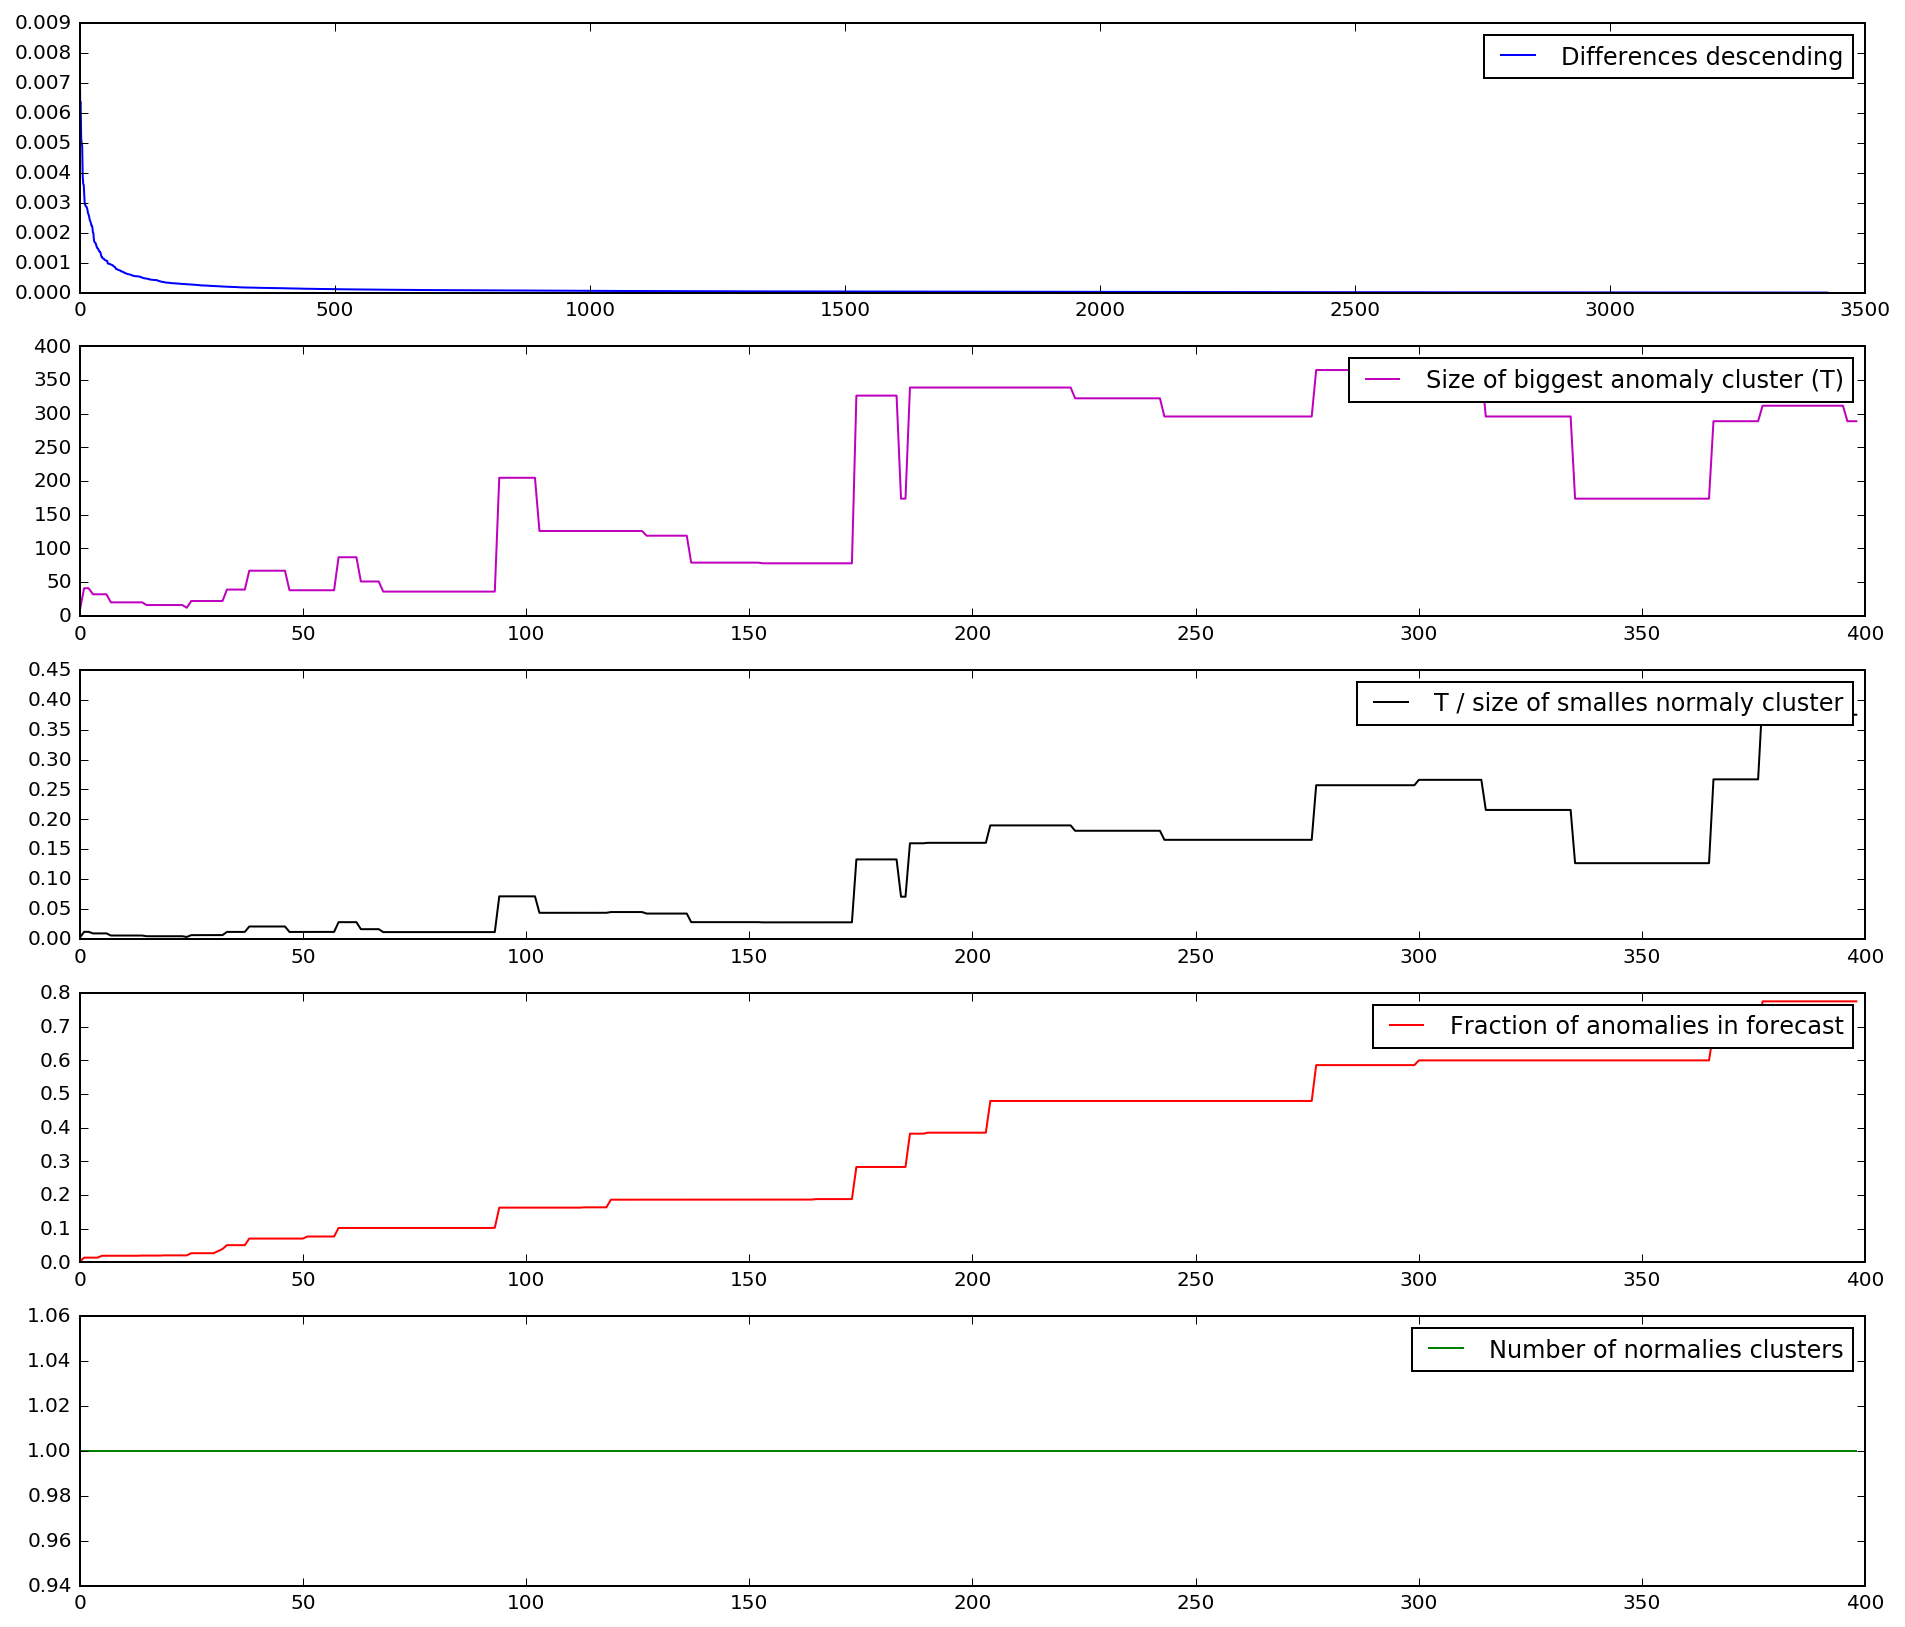

In [76]:
exp.analize_threshold(normaly_score, anomaly_score, 400, 1)

In [77]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

bound variant: n_splits= 277 T =  296 T_frac =  0.165826330532 , anom_frac =  0.479288214702


хм, вообще сказано, что на трейне 7% аномалий...
поэтому результат совсем не тот, но окей

In [79]:
exp.submit_variants(normaly_score, anomaly_score, 0.1, 0.5)

bound variant: n_splits= 58 T =  38 T_frac =  0.0120063191153 , anom_frac =  0.0767211201867


T =  38
T_frac =  0.0120063191153
Anomalies Fraction =  0.0767211201867 %


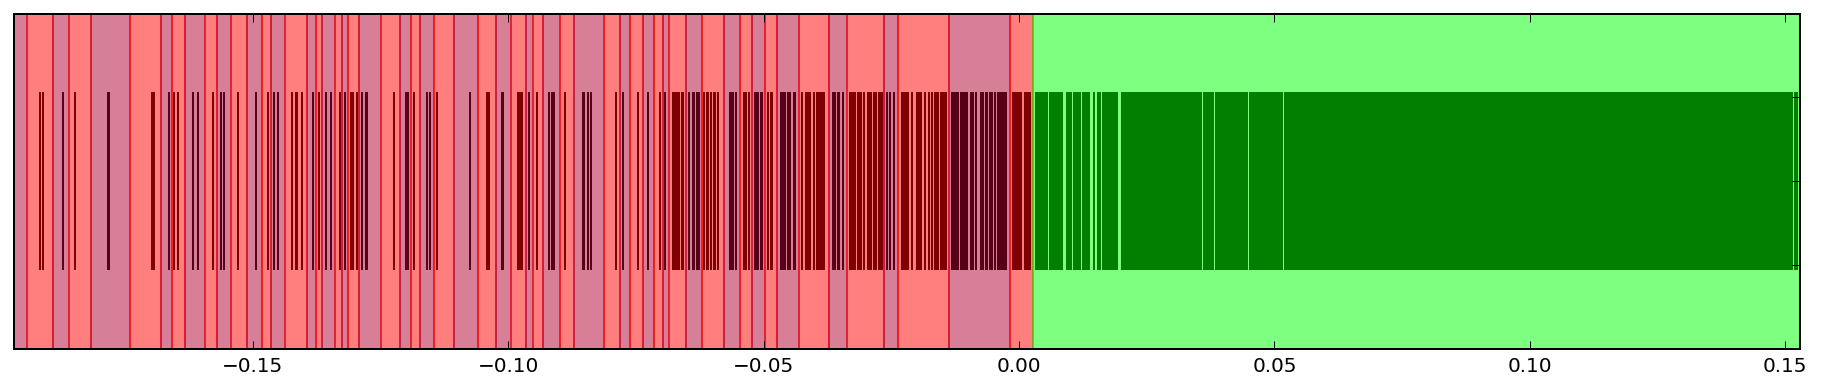

In [81]:
f = exp.apply_threshold(normaly_score, anomaly_score, 58, 1)

In [82]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.277566539924
recall =  0.292
f-measure =  0.284600389864


0.28460038986354774

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.309368191721  (thr =  -0.0120562249031 )


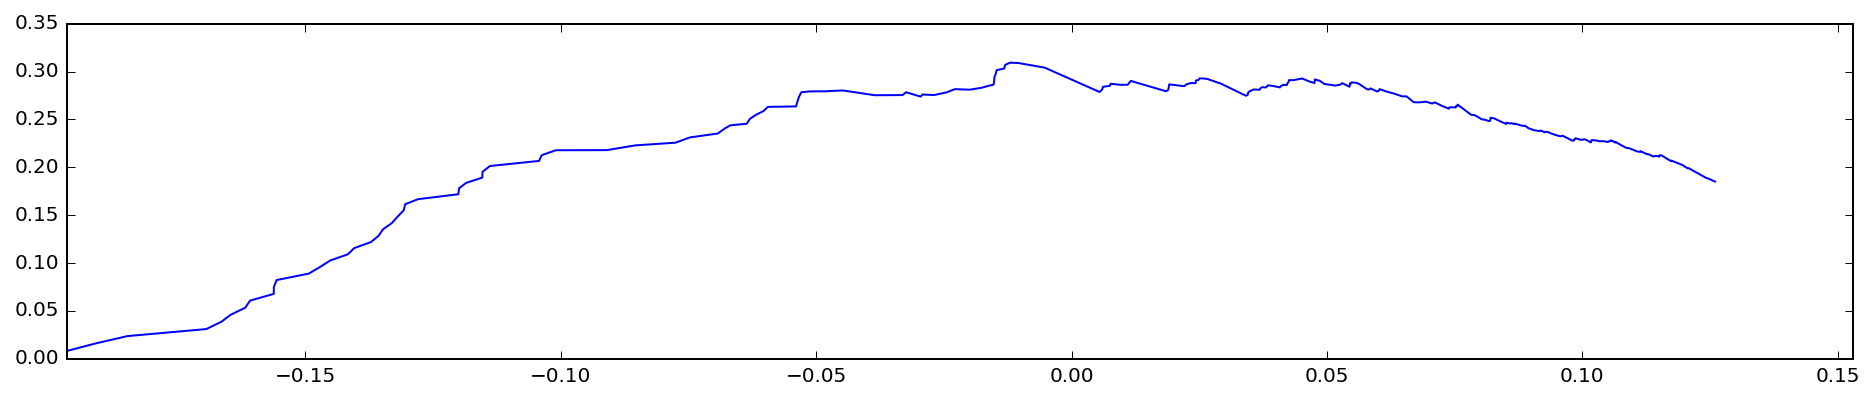

In [83]:
exp.potential_f_measure(normaly_score, anomaly_score)

# SHUTTLE

Датасет от NASA, по 9 вещественным признакам определить какую-то характеристику то ли самого шаттла, то ли его фотографии (описание датасета составлено так, чтобы пользователи о таких вещах не задумывались о\_О).

Исходная задача - задача классификации, всего классов 7, однако доля 1-го класса составляет 80%. В статье по IsolationForest, похоже что, сжульничали: почему-то не считали аномалиями 4-ый класс. Возможно, так у них показатели лучше)) Я пока сделаю также.

In [5]:
DF = pd.read_csv("shuttle.txt", sep=' ', header=None)
del DF[9]

DF_test = pd.read_csv("shuttle_test.txt", sep=' ', header=None)
ans = (DF_test[9] == 2) | (DF_test[9] == 3) | (DF_test[9] == 5) | (DF_test[9] == 6) | (DF_test[9] == 7)
del DF_test[9]

DF

,0,1,2,3,4,5,6,7,8
0,50,21,77,0,28,0,27,48,22
1,55,0,92,0,0,26,36,92,56
2,53,0,82,0,52,-5,29,30,2
3,37,0,76,0,28,18,40,48,8
4,37,0,79,0,34,-26,43,46,2
5,85,0,88,-4,6,1,3,83,80
6,56,0,81,0,-4,11,25,86,62
7,55,-1,95,-3,54,-4,40,41,2
8,53,8,77,0,28,0,23,48,24
9,37,0,101,-7,28,0,64,73,8


Решение через полиномы выдаёт memory error. Видимо, нужно попробовать посэмплировать!!!

AUC-ROC score:  0.987907251647


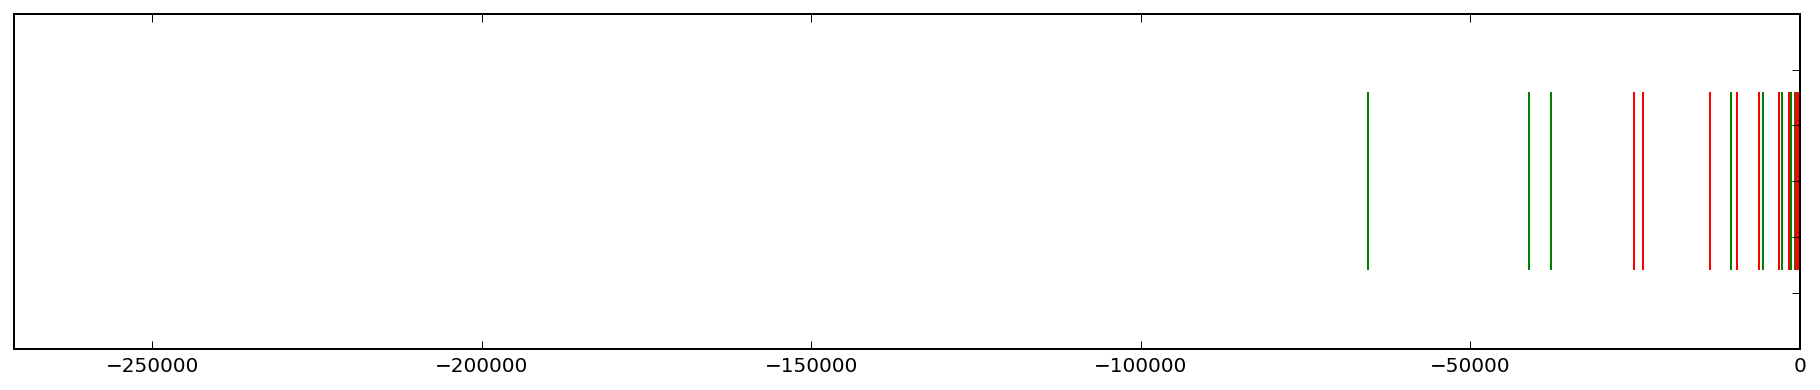

In [6]:
normaly_score, anomaly_score = exp.Solve(exp.BaggingPolynomSolver(n_estimators=1, max_samples=250), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.987511729248


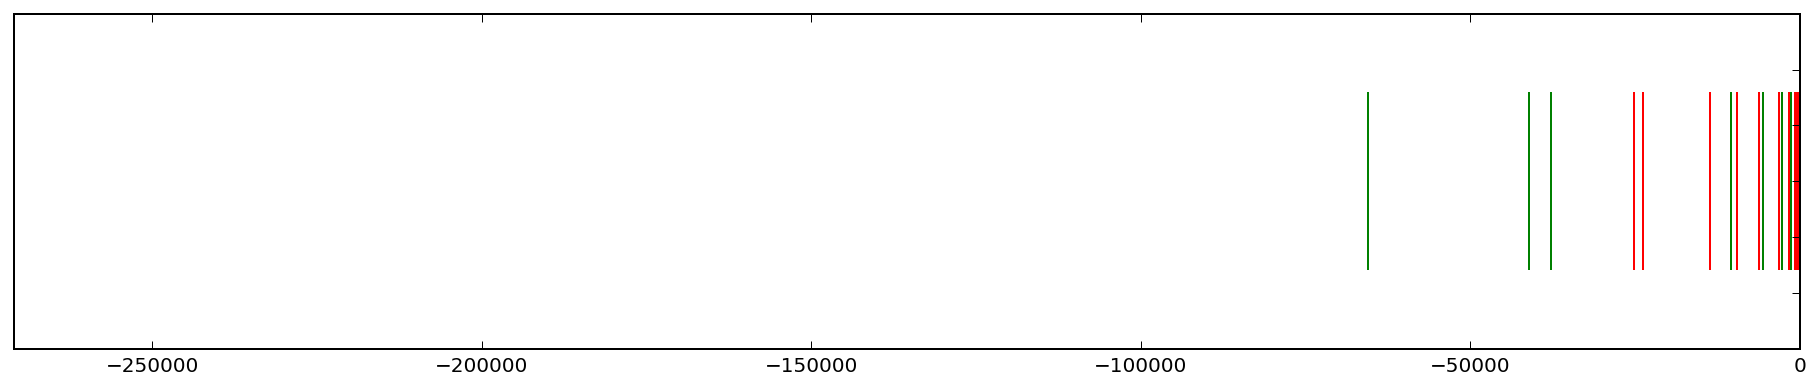

In [8]:
normaly_score, anomaly_score = exp.Solve(exp.BaggingPolynomSolver(n_estimators=100, max_samples=250), DF, DF_test[~ans], DF_test[ans])

прикольный результат))) Это было на Чебышёвской метрике

AUC-ROC score:  0.988656248395


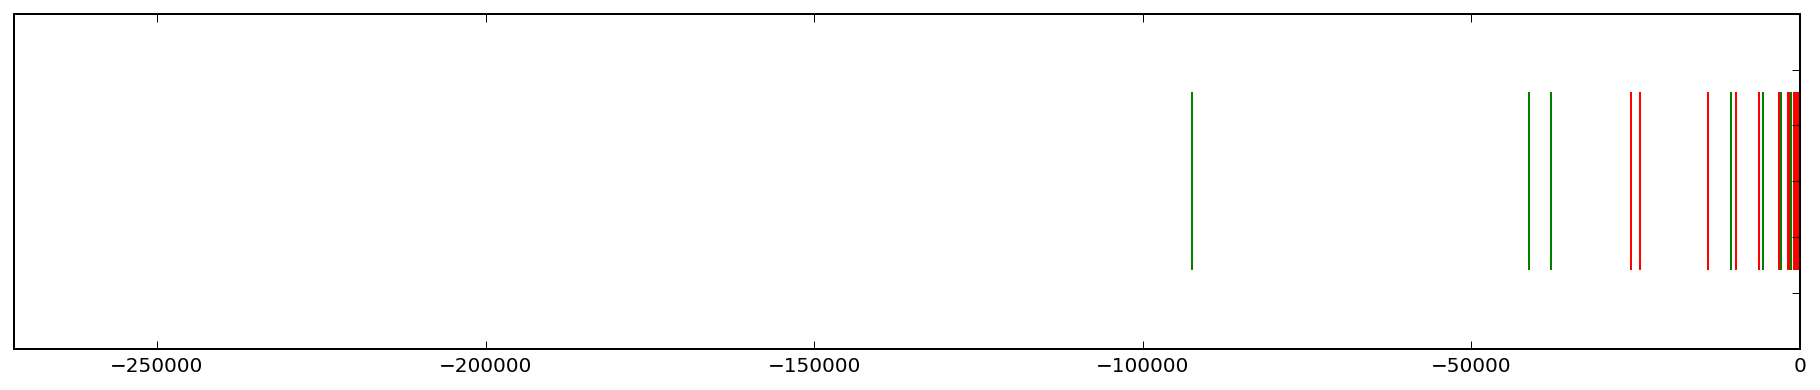

In [10]:
normaly_score, anomaly_score = exp.Solve(exp.BaggingPolynomSolver(metric='euclidean'), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.990755097522


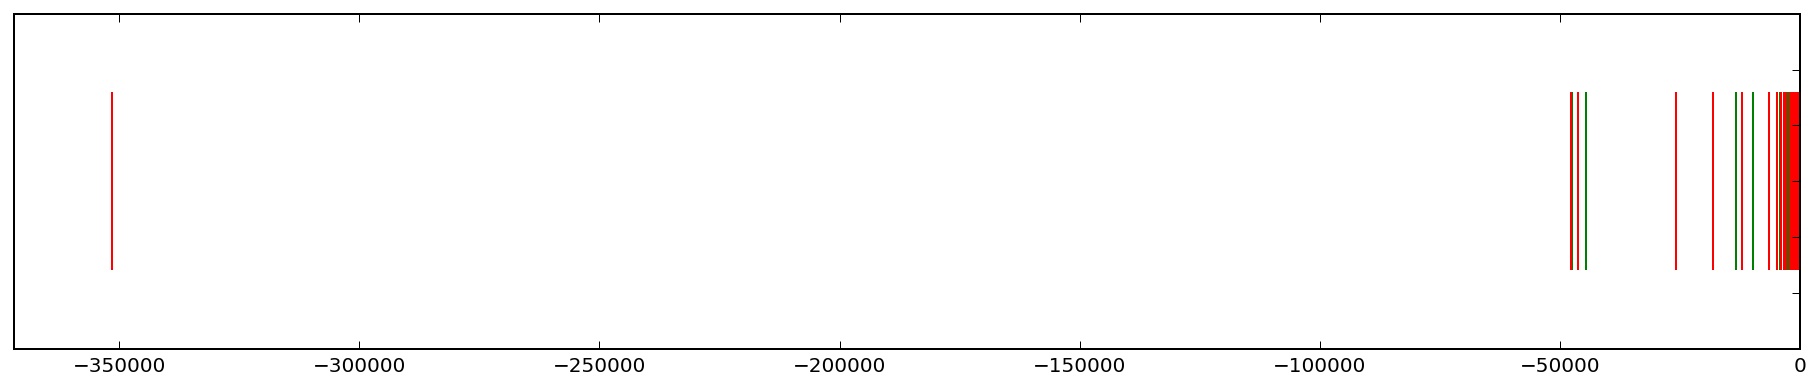

In [9]:
normaly_score, anomaly_score = exp.Solve(exp.BaggingPolynomSolver(metric='manhattan'), DF, DF_test[~ans], DF_test[ans])

AUC-ROC score:  0.991949702072


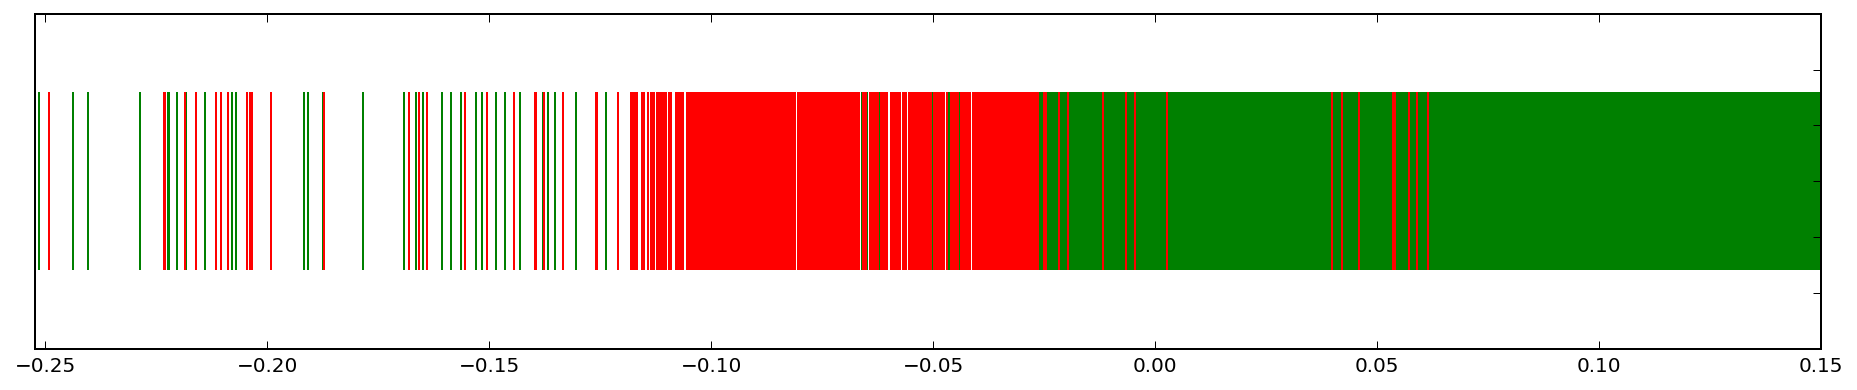

In [87]:
normaly_score, anomaly_score = exp.Solve(exp.modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

chebyshev: 0.578185022026

euclidean: 0.618375078666

AUC-ROC score:  0.994812184391


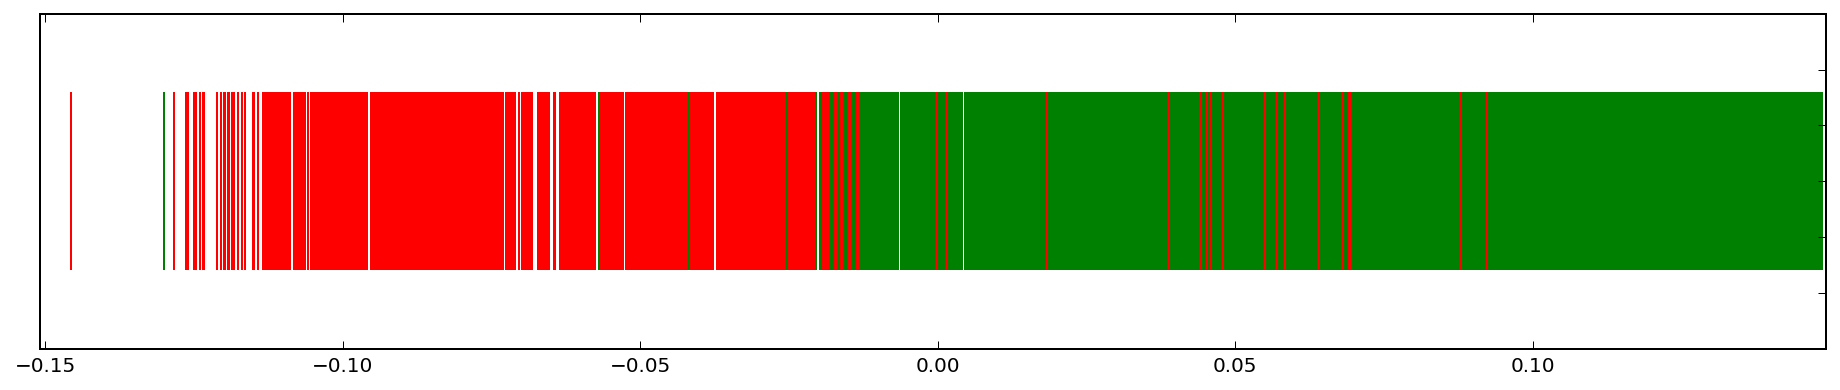

In [5]:
normaly_score, anomaly_score = exp.Solve(IsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

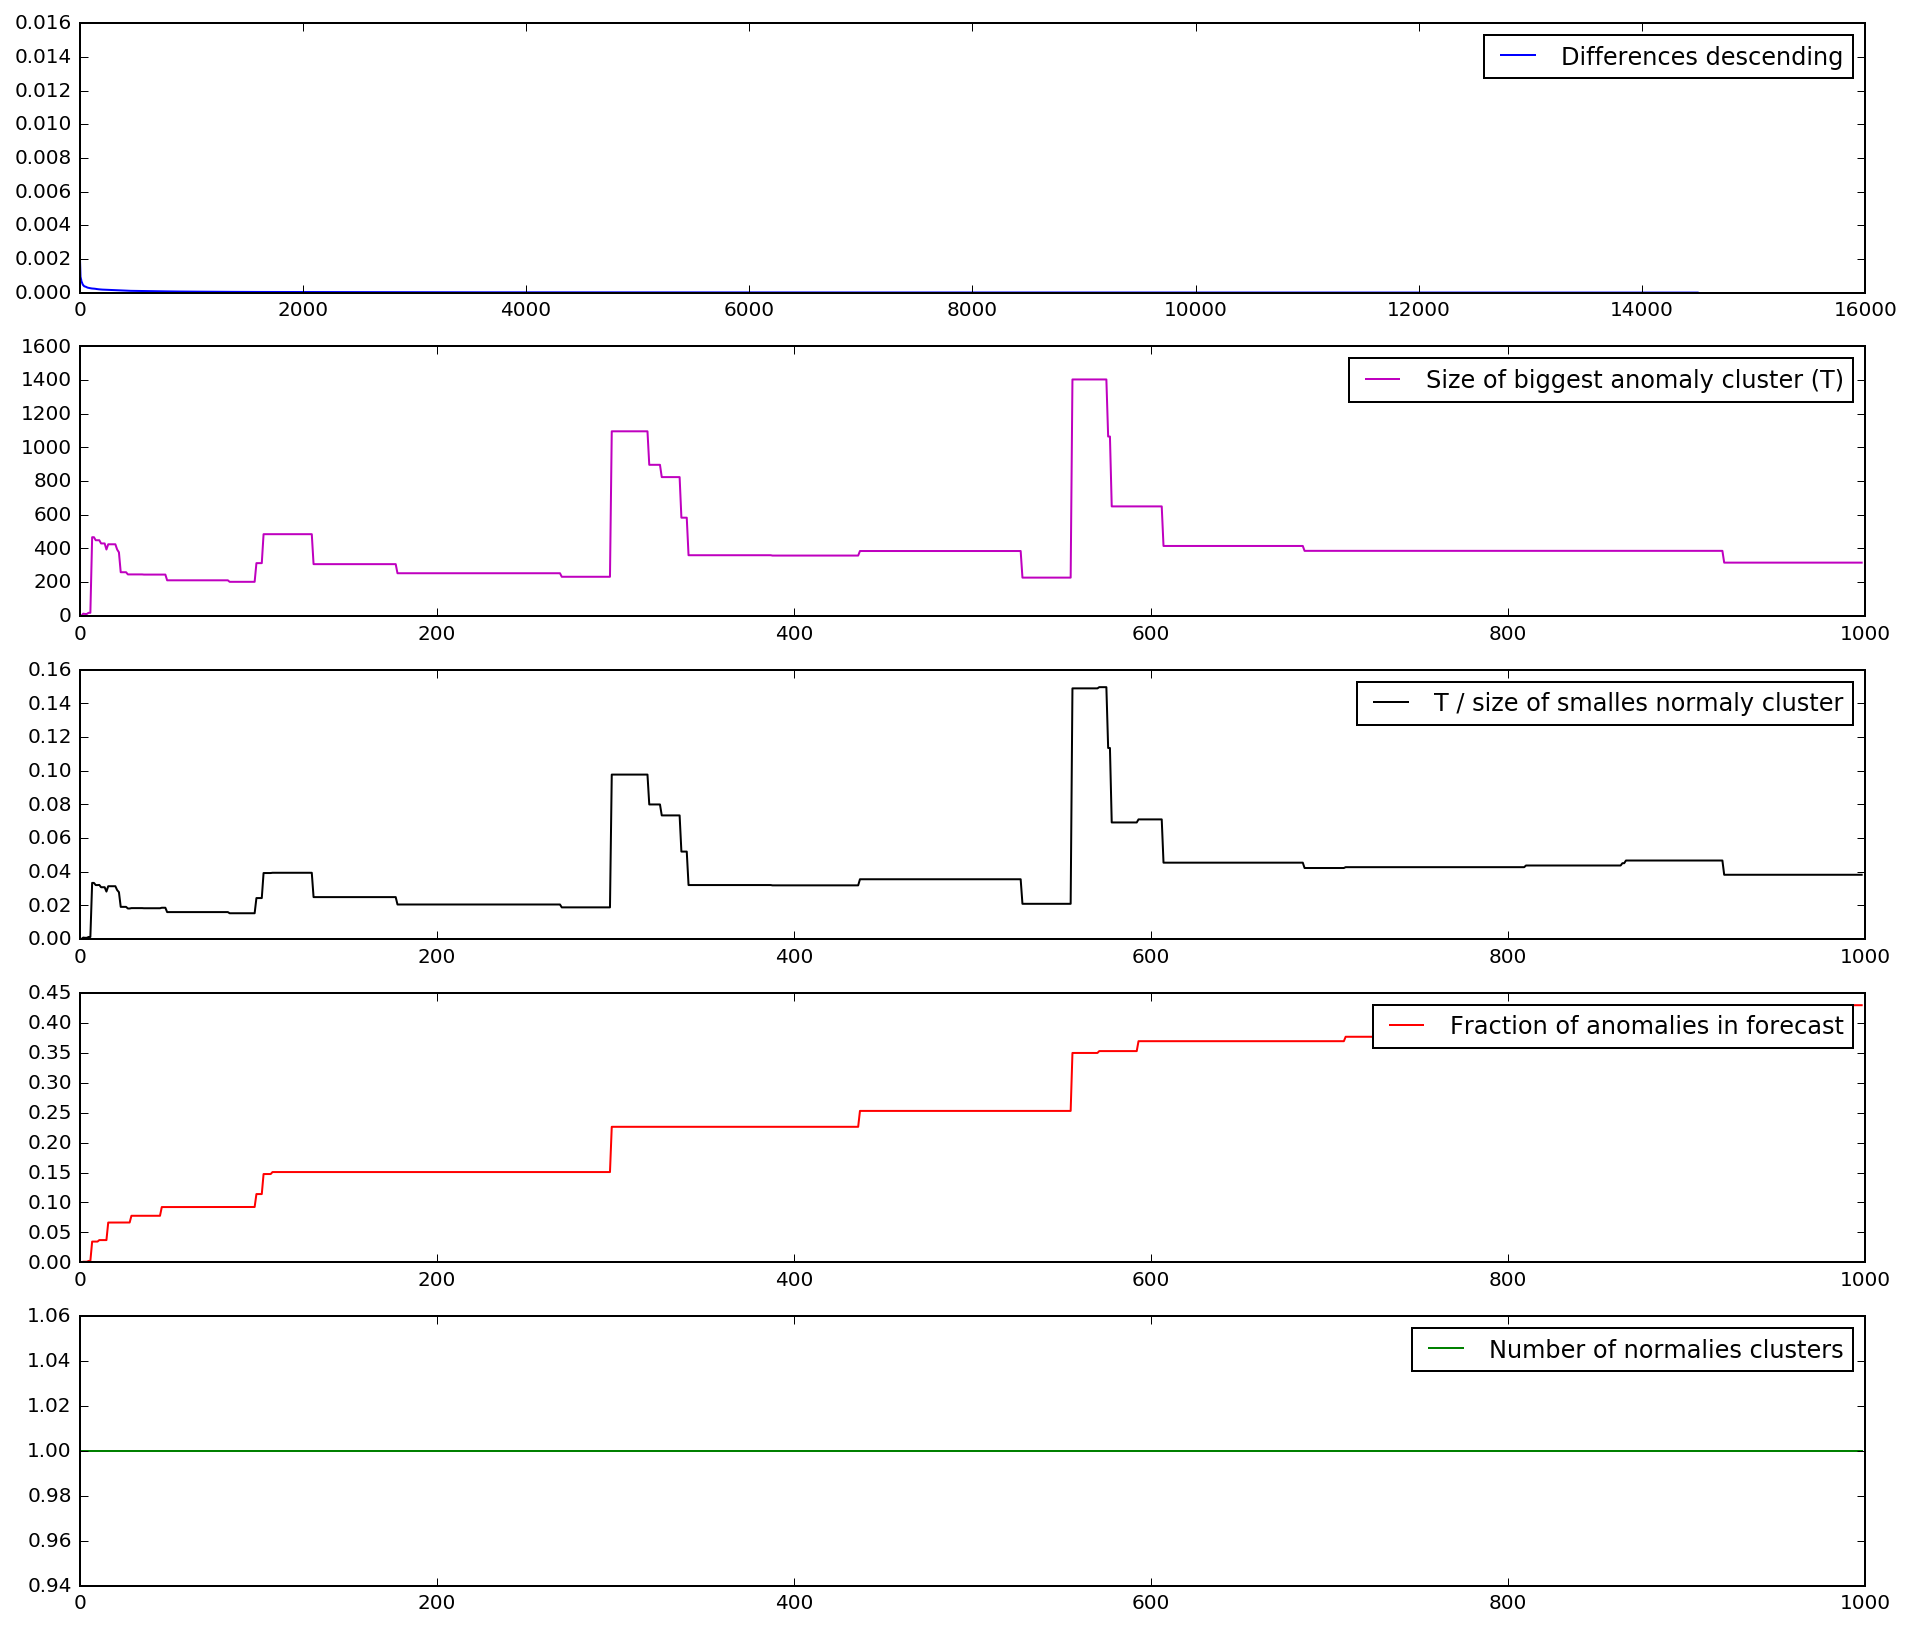

In [7]:
exp.analize_threshold(normaly_score, anomaly_score, 1000, 1)

In [8]:
exp.submit_variants(normaly_score, anomaly_score, 0.5, 0.5)

bound variant: n_splits= 1186 T =  789 T_frac =  0.107303141575 , anom_frac =  0.492896551724


ну вот на трейне < 20% аномалий...

In [9]:
exp.submit_variants(normaly_score, anomaly_score, 0.2, 0.5)

bound variant: n_splits= 298 T =  232 T_frac =  0.0188418744416 , anom_frac =  0.150827586207


T =  232
T_frac =  0.0188418744416
Anomalies Fraction =  0.150827586207 %


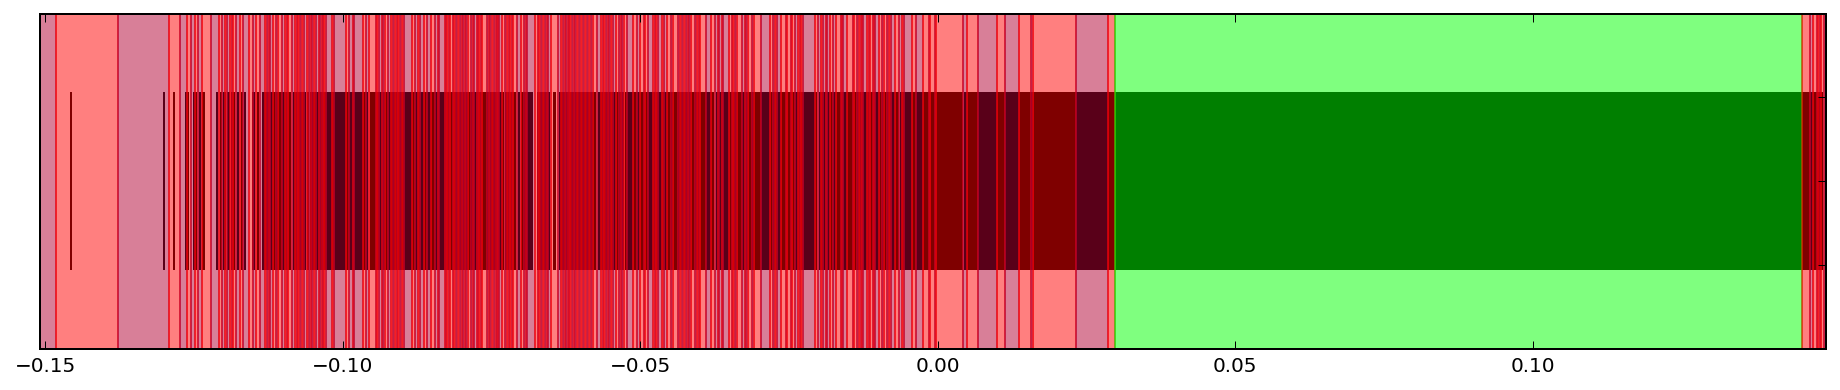

In [10]:
f = exp.apply_threshold(normaly_score, anomaly_score, 298, 1)

In [11]:
exp.f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.390032007316
recall =  0.983852364475
f-measure =  0.558611656843


0.55861165684348402

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.914285714286  (thr =  -0.0233158907935 )


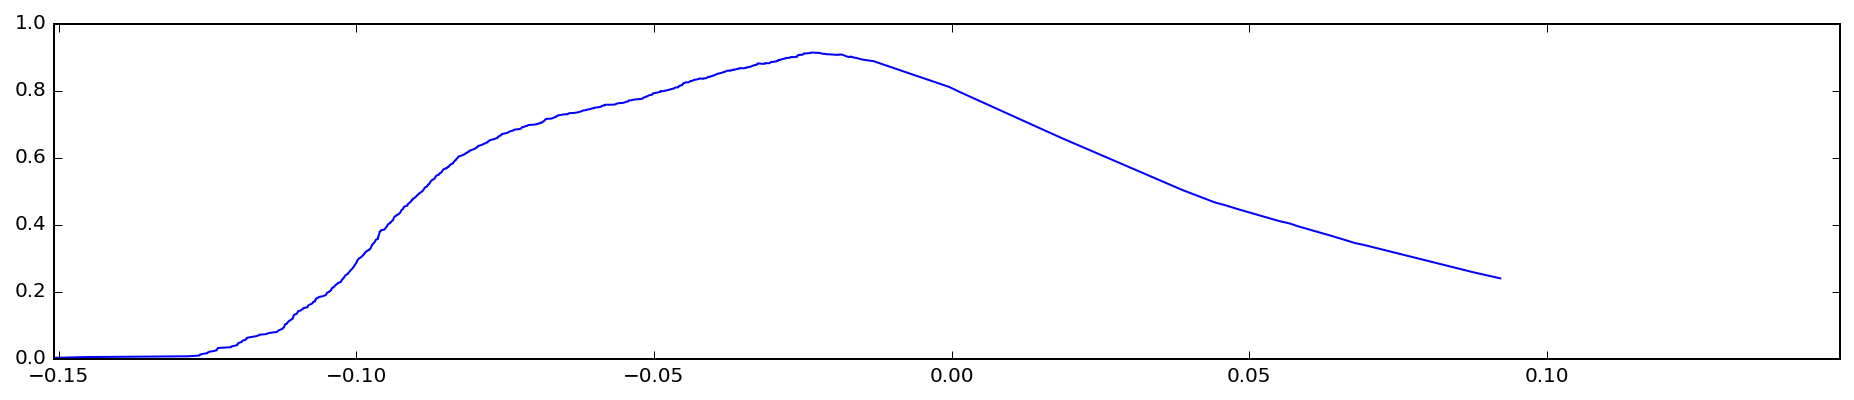

In [12]:
exp.potential_f_measure(normaly_score, anomaly_score)

То есть 0.15 аномалий - это много? :( всхлип